In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,BatchNormalization,Dense,Flatten,MaxPooling2D,Activation,Dropout
from tensorflow.keras.models import Sequential
import numpy as np
import os
import time
from sklearn.model_selection import train_test_split
import json
import cv2
import math
from skopt.space import Real, Categorical, Integer
from skopt import gp_minimize
from skopt.utils import use_named_args
from tensorflow.keras.backend import clear_session

In [2]:
output_shape=136
input_shape=(172,172,1,)
split=0.8

In [3]:
def load_dataset():
    datasetPath=r"D:\Desktop\cours\3I\DetectionVisage\68_face_landmarks/dataset"
    X_train=[]
    X_test=[]
    y_train=[]
    y_test=[]
    files=[]
    for root,dirs,allfiles in os.walk(datasetPath):
        for file in allfiles:
            if 'jpg' in file or 'png' in file or "txt" in file:
                files.append(root+'/'+file)
    files.sort()
    for file in files:
        landmarks=[]
        if "trainset" in file:
            if '.jpg' in file or ".png" in file:
                X_train+=[getImage(file)]
            elif '.txt' in file:
                with open(file,'r',encoding='utf8') as f:
                    lines=f.readlines()
                for line in lines:
                    if "n_points" not in line and "version" not in line and "{" not in line and "}" not in line:
                        tmp=line.split(" ")
                        landmarks+=[float(tmp[0]),float(tmp[1])]
                y_train.append(landmarks)
        else:
            if '.jpg' in file or ".png" in file:
                X_test+=[getImage(file)]
            elif '.txt' in file:
                with open(file,'r',encoding="utf8") as f:
                    lines=f.readlines()
                for line in lines:
                    if "n_points" not in line and "version" not in line and "{" not in line and "}" not in line:
                        tmp=line.split(" ")
                        landmarks+=[float(tmp[0]),float(tmp[1])]
                y_test.append(landmarks)
    print(len(X_train))
    print(len(y_train))
    print(len(X_test))
    print(len(y_test))
    X_train=np.array(X_train)
    X_test=np.array(X_test)
    y_test=np.array(y_test)
    y_train=np.array(y_train)
    y_train = np.reshape( y_train , ( -1 , 1 , 1 , output_shape ))
    y_test = np.reshape( y_test , ( -1 , 1 , 1 , output_shape ))
    return X_train,y_train,X_test,y_test
def load_dataset_json(split=0.8, output_shape=1):
    offset=172/512
    datasetPath = os.path.join("D:", "\\Desktop", "cours", "3I", "Dataset")
    X = []
    y = []
    with open(os.path.join(datasetPath, "all_data_augmented.json")) as file:
        data = json.load(file)
    for key in data:
        item = data[key]
        file_path = os.path.join(datasetPath, "images", item["file_name"])
        X.append(getImage(file_path))
        array=np.array(item["face_landmarks"])
        y.append(list(array.flat))
    X = np.array(X) / 255
    y = np.array(y)*offset
    X= np.expand_dims(X, axis=-1)
    y=np.expand_dims(y,axis=(1,2))
    return  train_test_split(X, y, train_size=split)

def getImage(path):
    img=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    img=cv2.resize(img,(172,172))
    return img
    

In [4]:
X_train,X_test,y_train,y_test=load_dataset_json()

In [5]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8000, 172, 172, 1)
(8000, 1, 1, 136)
(2000, 172, 172, 1)
(2000, 1, 1, 136)


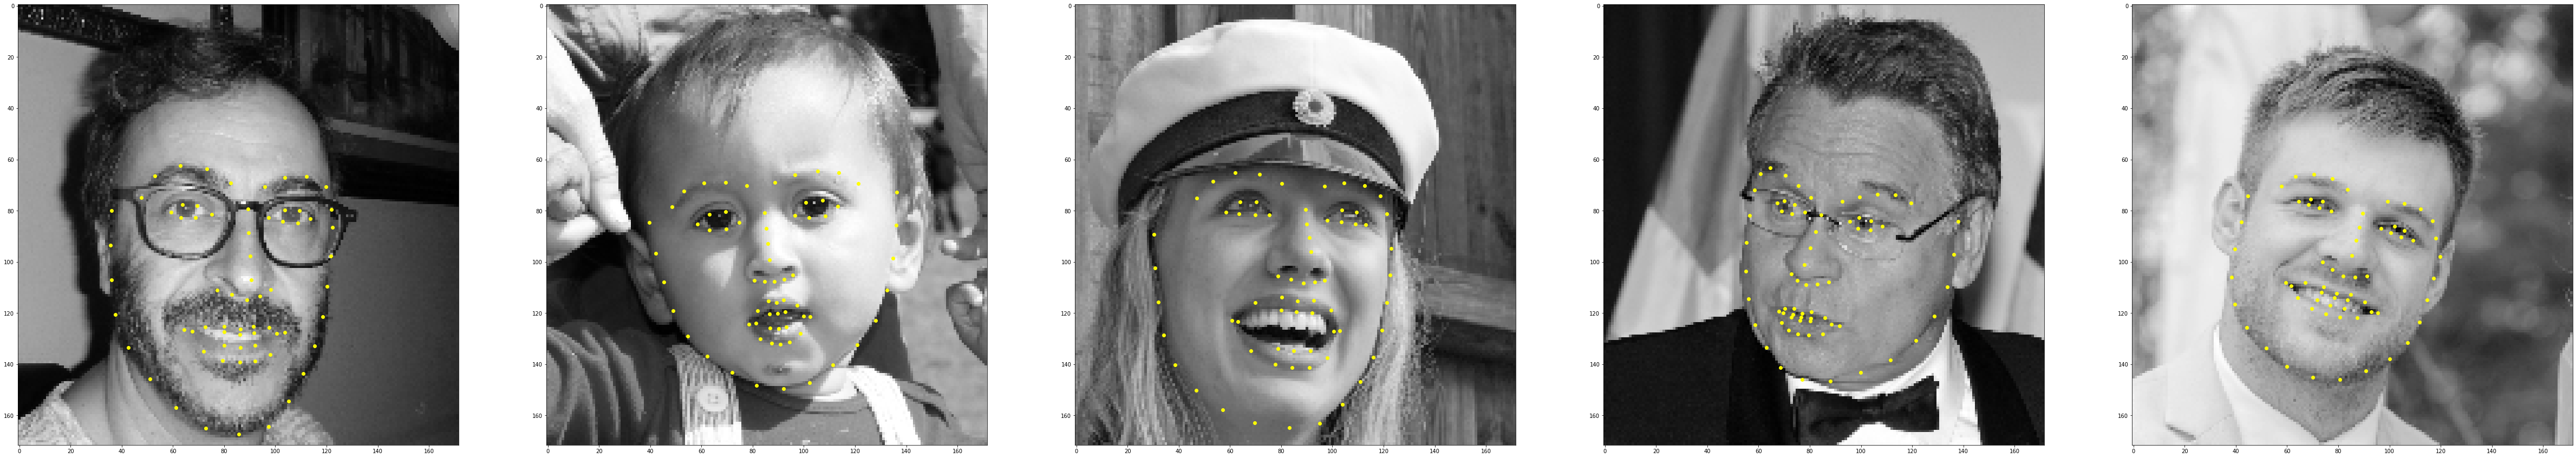

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=( 172 , 172 ))
for i in range( 1 , 6 ):
    sample_image = X_test[i]
    landmarks=y_test[i][0][0]
    fig.add_subplot( 1 , 10 , i )
    plt.imshow( sample_image , cmap='gray' )
    for j in range(0,136,2):
        plt.scatter( landmarks[j],landmarks[j+1], c='yellow' )
    
plt.show()

In [7]:
Callback=tf.keras.callbacks.ModelCheckpoint(
    '../model_best_loss.h5', monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch'
)
early_stop=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)
def getCoeff(x):
    return int(34.667*pow(x,4) - 432*pow(x,3) + 1853.3*pow(x,2) - 3184*x + 1984)

def getNeurons(x,max_neurons):
    return int((max_neurons*pow(math.sin(x*0.25),2)+max_neurons*pow(math.cos(x*0.75),2))/2)

In [ ]:
model_layers = [
                
    Conv2D( 256 , input_shape=input_shape , kernel_size=( 3 , 3 ) ,  activation='relu' ),
    Conv2D( 256 , kernel_size=( 3 , 3 ) , activation='relu' ),
    BatchNormalization(),

    Conv2D( 128 , kernel_size=( 3 , 3 ) ,  activation='relu' ),
    Conv2D( 128 , kernel_size=( 3 , 3 ) ,  activation='relu' ),
    BatchNormalization(),

    Conv2D( 256 , kernel_size=( 3 , 3 ) , activation='relu' ),
    Conv2D( 256 , kernel_size=( 3 , 3 ) , activation='relu' ),
    BatchNormalization(),

    Conv2D( 128 , kernel_size=( 3 , 3 ) , activation='relu' ),
    Conv2D( 128 , kernel_size=( 3 , 3 ) , activation='relu' ),
    BatchNormalization(),

    Conv2D( 64 , kernel_size=( 3 , 3 ) , activation='relu' ),
    Conv2D( 64 , kernel_size=( 3 , 3 ) , activation='relu' ),
    BatchNormalization(),

    Conv2D( output_shape, kernel_size=( 3 , 3 ) , activation='relu' ),
    Conv2D( output_shape , kernel_size=( 3 , 3 ) , activation='relu' ),
    Conv2D( output_shape , kernel_size=( 3 , 3 ) ),

]
model = tf.keras.Sequential( model_layers )
model.compile( loss=tf.keras.losses.mean_squared_error,optimizer='Adam')


In [ ]:
# model.fit(X_train,y_train,batch_size=16,epochs=80,validation_data=(X_test,y_test),callbacks=[Callback])

In [ ]:
def create_model(layer_number=1,max_neurons=128,kernel_size=1,dropout=0.1):
    kernel_size=(kernel_size,kernel_size)
    model=Sequential()
    model.add(BatchNormalization(input_shape=input_shape))
    for i in range(layer_number):
        try:
            model.add(Conv2D(getNeurons(i,max_neurons),kernel_size,activation='relu'))
            model.add(Conv2D(getNeurons(i,max_neurons),kernel_size,activation='relu'))
            model.add(BatchNormalization())
            model.add(Dropout(dropout))
        except:
            pass
    model.add(Conv2D( output_shape, kernel_size=kernel_size , activation='relu' ))
    model.add(Conv2D( output_shape , kernel_size=kernel_size , activation='relu' ))
    model.add(Conv2D( output_shape , kernel_size=kernel_size))
    model.compile(loss="mse")
    return model


In [ ]:
# best_loss=tf.keras.models.load_model('./best_model_loss.h5').evaluate(X_test,y_test)
# tf.keras.models.load_model('./best_model_loss.h5').summary()
dim_num_conv_layers = Integer(low=1, high=7, name='layer_number')
dim_num_kernel_size=Integer(low=1,high=3,name="kernel_size")
dim_num_conv_nodes = Integer(low=64, high=256, name='max_neurons')
dim_num_dropout = Real(low=0.1, high=0.5, name='dropout')

dimensions = [dim_num_conv_layers,
              dim_num_conv_nodes,
              dim_num_kernel_size,
              dim_num_dropout,
             ]
default_parameters = [1, 64, 1, 0.1]

In [ ]:
class change_best_loss_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        global best_loss
        if logs!=None:
            if best_loss>logs['val_loss']:
                best_loss=logs['val_loss']

In [ ]:
best_loss=-1
@use_named_args(dimensions=dimensions)
def fitness(layer_number=1,max_neurons=128,kernel_size=(1,1),dropout=0.1):

    # Print the hyper-parameters.
    print('layer_number: ',layer_number)
    print('max_neurons: ', max_neurons)
    print('kernel_size: ', kernel_size)
    print('dropout: ', dropout)
    print()
    
    # Create the neural network with these hyper-parameters.
    model = create_model(layer_number=layer_number,
                         max_neurons=max_neurons,
                         kernel_size=kernel_size,
                         dropout=dropout
                        )
    # Use Keras to train the model.
    history = model.fit(x= X_train,
                        y= y_train,
                        epochs=50,
                        batch_size=16,
                        validation_data=(X_test,y_test),
                        callbacks=[Callback,early_stop]
                       )

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    loss = history.history['val_loss'][-1]
    # Print the classification accuracy.
    print()
    print("MSE: {0:.2%}".format(loss))
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_loss

    # If the classification accuracy of the saved model is improved ...
    if loss < best_loss or best_loss==-1:
        # Save the new model to harddisk.
        model.save('./best_model_loss.h5')
        print("model saved")
        # Update the classification accuracy.
        best_loss = loss
    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    clear_session()
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.
    return loss
# This function exactly comes from :Hvass-Labs, TensorFlow-Tutorials

In [ ]:
fitness(default_parameters)

In [ ]:
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=50,
                            x0=default_parameters)

In [15]:
def create_model_2(neurons_1=256,has_layer_1=True, has_2_conv_layer_1=True,neurons_2=16,has_layer_2=True, has_2_conv_layer_2=True,neurons_3=256,has_layer_3=True, has_2_conv_layer_3=True,neurons_4=64,has_layer_4=True, has_2_conv_layer_4=True,neurons_5=16,has_layer_5=True, has_2_conv_layer_5=True,drop_1=0.5,drop_2=0.4,drop_3=0.3,drop_4=0.2,drop_5=0.1,dense_1=0.7*output_shape,dense_2=0.5*output_shape):
    model_2=Sequential()
    model_2.add(BatchNormalization(input_shape=input_shape))
    if has_layer_1:
        model_2.add(Dropout(drop_1))
        model_2.add(Conv2D(neurons_1,kernel_size=(3,3),activation='relu'))
        if has_2_conv_layer_1:
            model_2.add(Conv2D(neurons_1,kernel_size=(3,3),activation='relu'))
        model_2.add(BatchNormalization())

    if has_layer_2:
        model_2.add(Dropout(drop_2))
        model_2.add(Conv2D(neurons_2,kernel_size=(3,3),activation='relu'))
        if has_2_conv_layer_2:
            model_2.add(Conv2D(neurons_2,kernel_size=(3,3),activation='relu'))
        model_2.add(BatchNormalization())

    if has_layer_3:
        model_2.add(Dropout(drop_3))
        model_2.add(Conv2D(neurons_3,kernel_size=(3,3),activation='relu'))
        if has_2_conv_layer_3:
            model_2.add(Conv2D(neurons_3,kernel_size=(3,3),activation='relu'))
        model_2.add(BatchNormalization())

    if has_layer_4:
        model_2.add(Dropout(drop_4))
        model_2.add(Conv2D(neurons_4,kernel_size=(3,3),activation='relu'))
        if has_2_conv_layer_4:
            model_2.add(Conv2D(neurons_4,kernel_size=(3,3),activation='relu'))
        model_2.add(BatchNormalization())

    if has_layer_5:
        model_2.add(Dropout(drop_5))
        model_2.add(Conv2D(neurons_5,kernel_size=(3,3),activation='relu'))
        if has_2_conv_layer_5:
            model_2.add(Conv2D(neurons_5,kernel_size=(3,3),activation='relu'))
        model_2.add(BatchNormalization())
    
    model_2.add(Conv2D(dense_1,kernel_size=(3,3),activation='relu'))
    model_2.add(BatchNormalization())
    model_2.add(Conv2D(dense_2,kernel_size=(3,3),activation='relu'))
    model_2.add(BatchNormalization())
    model_2.add(Conv2D(output_shape,kernel_size=(3,3)))

    model_2.compile(loss=tf.keras.losses.mean_squared_error,optimizer='Adam')
    
    return model_2
mode=create_model_2()

In [6]:
callback=tf.keras.callbacks.ModelCheckpoint(
    '../model_best_loss.h5',
    monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch'
)
early_stop=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)
reduce_lr =tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9,
                              patience=20, min_lr=0.000000000000001)

In [18]:

best_accuracy=-1
dim_num_neurons_1 = Integer(low=8, high=256, name='neurons_1')
dim_has_layer_1=Categorical([True,False],name='has_layer_1')
dim_has_2_layer_1=Categorical([True,False],name='has_2_conv_layer_1')

dim_num_neurons_2 = Integer(low=8, high=256, name='neurons_2')
dim_has_layer_2=Categorical([True,False],name='has_layer_2')
dim_has_2_layer_2=Categorical([True,False],name='has_2_conv_layer_2')

dim_num_neurons_3= Integer(low=8, high=256, name='neurons_3')
dim_has_layer_3=Categorical([True,False],name='has_layer_3')
dim_has_2_layer_3=Categorical([True,False],name='has_2_conv_layer_3')

dim_num_neurons_4 = Integer(low=8, high=256, name='neurons_4')
dim_has_layer_4=Categorical([True,False],name='has_layer_4')
dim_has_2_layer_4=Categorical([True,False],name='has_2_conv_layer_4')

dim_num_neurons_5 = Integer(low=8, high=256, name='neurons_5')
dim_has_layer_5=Categorical([True,False],name='has_layer_5')
dim_has_2_layer_5=Categorical([True,False],name='has_2_conv_layer_5')

dim_num_dropout_1=Real(low=0.1,high=0.6,name='drop_1')
dim_num_dropout_2=Real(low=0.1,high=0.6,name='drop_2')
dim_num_dropout_3=Real(low=0.1,high=0.6,name='drop_3')
dim_num_dropout_4=Real(low=0.1,high=0.6,name='drop_4')
dim_num_dropout_5=Real(low=0.1,high=0.6,name='drop_5')

dim_num_dense_1=Integer(low=8,high=output_shape,name='dense_1')
dim_num_dense_2=Integer(low=8,high=output_shape,name='dense_2')


dimensions2 = [dim_num_neurons_1,
                dim_has_layer_1,
                dim_has_2_layer_1,

                dim_num_neurons_2,
                dim_has_layer_2,
                dim_has_2_layer_2,

                dim_num_neurons_3,
                dim_has_layer_3,
                dim_has_2_layer_3,

                dim_num_neurons_4,
                dim_has_layer_4,
                dim_has_2_layer_4,
               
                dim_num_neurons_5,
                dim_has_layer_5,
                dim_has_2_layer_5,

                dim_num_dropout_1,
                dim_num_dropout_2,
                dim_num_dropout_3,
                dim_num_dropout_4,
                dim_num_dropout_5,
                dim_num_dense_1,
                dim_num_dense_2
             ]



default_parameters2 = [8,False,False,8,False,False,8,False,False,8,False,False,8,True,False,0.1,0.1,0.1,0.1,0.1,8,8]
@use_named_args(dimensions=dimensions2)
def fitness2(neurons_1=256,has_layer_1=True, has_2_conv_layer_1=True,neurons_2=16,has_layer_2=True, has_2_conv_layer_2=True,neurons_3=256,has_layer_3=True, has_2_conv_layer_3=True,neurons_4=64,has_layer_4=True, has_2_conv_layer_4=True,neurons_5=16,has_layer_5=True, has_2_conv_layer_5=True,drop_1=0.5,drop_2=0.4,drop_3=0.3,drop_4=0.2,drop_5=0.1,dense_1=0.7*output_shape,dense_2=0.5*output_shape):
    loss=9999
    try:
        model = create_model_2(neurons_1=neurons_1,
                               has_layer_1=has_layer_1,
                               has_2_conv_layer_1=has_2_conv_layer_1,
                             neurons_2=neurons_2,
                               has_layer_2=has_layer_2,
                               has_2_conv_layer_2=has_2_conv_layer_2,
                             neurons_3=neurons_3,
                               has_layer_3=has_layer_3,
                               has_2_conv_layer_3=has_2_conv_layer_3,
                             neurons_4=neurons_4,
                               has_layer_4=has_layer_4,
                               has_2_conv_layer_4=has_2_conv_layer_4,
                             neurons_5=neurons_5,
                               has_layer_5=has_layer_5,
                               has_2_conv_layer_5=has_2_conv_layer_5,
                             drop_1=drop_1,
                             drop_2=drop_2,
                             drop_3=drop_3,
                             drop_4=drop_4,
                             drop_5=drop_5,
                             dense_1=dense_1,
                             dense_2=dense_2
                            )
        model.summary()

        history = model.fit(x=X_train,
                            y=y_train,
                            epochs=128,
                            batch_size=16,
                            validation_data=(X_test,y_test),
                            callbacks=[callback]
                           )
        loss = history.history['val_loss'][-1]

        print()
        print("Loss: {0:.2%}".format(loss))
        print()

        del model
    except NameError:
        print("NameError")
    finally:
        
        clear_session()
        return loss
search_result = gp_minimize(func=fitness2,
                            dimensions=dimensions2,
                            acq_func='EI', # Expected Improvement.
                            n_calls=100,
                            x0=default_parameters2,
                           )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_8 (Batc  (None, 96, 96, 1)        4         
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 96, 96, 1)         0         
                                                                 
 conv2d_13 (Conv2D)          (None, 94, 94, 8)         80        
                                                                 
 batch_normalization_9 (Batc  (None, 94, 94, 8)        32        
 hNormalization)                                                 
                                                                 
 conv2d_14 (Conv2D)          (None, 92, 92, 8)         584       
                                                                 
 batch_normalization_10 (Bat  (None, 92, 92, 8)       

 batch_normalization_2 (Batc  (None, 90, 90, 160)      640       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 90, 90, 160)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 88, 88, 193)       278113    
                                                                 
 batch_normalization_3 (Batc  (None, 88, 88, 193)      772       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 88, 88, 193)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 86, 86, 139)       241582    
                                                                 
 batch_normalization_4 (Batc  (None, 86, 86, 139)      556       
 hNormaliz

Epoch 58/128
250/250 [==============================] - 55s 218ms/step - loss: 9.9722 - val_loss: 11.1725
Epoch 59/128
250/250 [==============================] - 55s 218ms/step - loss: 9.9960 - val_loss: 9.8783
Epoch 60/128
250/250 [==============================] - 55s 218ms/step - loss: 9.9607 - val_loss: 9.9634
Epoch 61/128
250/250 [==============================] - 55s 218ms/step - loss: 9.9722 - val_loss: 10.3245
Epoch 62/128
250/250 [==============================] - 55s 218ms/step - loss: 9.9573 - val_loss: 9.8571
Epoch 63/128
250/250 [==============================] - 55s 218ms/step - loss: 9.9351 - val_loss: 9.9318
Epoch 64/128
250/250 [==============================] - 55s 218ms/step - loss: 9.9397 - val_loss: 9.9293
Epoch 65/128
250/250 [==============================] - 55s 218ms/step - loss: 9.9253 - val_loss: 10.0798
Epoch 66/128
250/250 [==============================] - 54s 218ms/step - loss: 9.9611 - val_loss: 9.9852
Epoch 67/128
250/250 [==============================

 batch_normalization_1 (Batc  (None, 94, 94, 33)       132       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 94, 94, 33)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 204)       60792     
                                                                 
 batch_normalization_2 (Batc  (None, 92, 92, 204)      816       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 113)       207581    
                                                                 
 batch_normalization_3 (Batc  (None, 90, 90, 113)      452       
 hNormalization)                                                 
                                                                 
 conv2d_3 

 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 88, 88, 20)        21620     
                                                                 
 batch_normalization_3 (Batc  (None, 88, 88, 20)       80        
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 86, 86, 47)        8507      
                                                                 
 batch_normalization_4 (Batc  (None, 86, 86, 47)       188       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 84, 84, 136)       57664     
                                                                 
Total params: 339,979
Trainable params: 339,369
Non-trainable params: 610
__

Epoch 69/128
250/250 [==============================] - 17s 70ms/step - loss: 9.7739 - val_loss: 9.5869
Epoch 70/128
250/250 [==============================] - 17s 70ms/step - loss: 9.7749 - val_loss: 9.6453
Epoch 71/128
250/250 [==============================] - 17s 70ms/step - loss: 9.7631 - val_loss: 9.4941
Epoch 72/128
250/250 [==============================] - 17s 70ms/step - loss: 9.7620 - val_loss: 9.5535
Epoch 73/128
250/250 [==============================] - 17s 70ms/step - loss: 9.7666 - val_loss: 9.5806
Epoch 74/128
250/250 [==============================] - 17s 70ms/step - loss: 9.7517 - val_loss: 9.5892
Epoch 75/128
250/250 [==============================] - 17s 70ms/step - loss: 9.7411 - val_loss: 9.5938
Epoch 76/128
250/250 [==============================] - 17s 70ms/step - loss: 9.7517 - val_loss: 9.5690
Epoch 77/128
250/250 [==============================] - 17s 70ms/step - loss: 9.7491 - val_loss: 9.7467
Epoch 78/128
250/250 [==============================] - 17s 70ms

 conv2d_4 (Conv2D)           (None, 86, 86, 10)        9640      
                                                                 
 batch_normalization_4 (Batc  (None, 86, 86, 10)       40        
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 84, 84, 95)        8645      
                                                                 
 batch_normalization_5 (Batc  (None, 84, 84, 95)       380       
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 82, 82, 136)       116416    
                                                                 
Total params: 1,118,168
Trainable params: 1,116,886
Non-trainable params: 1,282
_________________________________________________________________
Epoch 1/128
250/250 [==============================] - 43s 158

 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 86, 86, 82)        149896    
                                                                 
 batch_normalization_4 (Batc  (None, 86, 86, 82)       328       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 84, 84, 87)        64293     
                                                                 
 batch_normalization_5 (Batc  (None, 84, 84, 87)       348       
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 82, 82, 136)       106624    
                                                                 
Total params: 764,994
Trainable params: 763,900
Non-trainable params: 1,094


                                                                 
 conv2d_3 (Conv2D)           (None, 88, 88, 65)        52130     
                                                                 
 batch_normalization_4 (Batc  (None, 88, 88, 65)       260       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 86, 86, 136)       79696     
                                                                 
Total params: 242,099
Trainable params: 241,527
Non-trainable params: 572
_________________________________________________________________
Epoch 1/128
250/250 [==============================] - 17s 60ms/step - loss: 1604.2803 - val_loss: 169.0611
Epoch 2/128
250/250 [==============================] - 14s 57ms/step - loss: 22.7435 - val_loss: 12.1436
Epoch 3/128
250/250 [==============================] - 14s 57ms/step - loss: 10.1746 - val_loss: 10.3618
Epoch 4/128
25

250/250 [==============================] - 14s 57ms/step - loss: 10.0077 - val_loss: 9.7104
Epoch 73/128
250/250 [==============================] - 14s 57ms/step - loss: 9.9939 - val_loss: 9.8099
Epoch 74/128
250/250 [==============================] - 14s 57ms/step - loss: 10.0242 - val_loss: 9.8552
Epoch 75/128
250/250 [==============================] - 14s 57ms/step - loss: 10.0259 - val_loss: 10.0107
Epoch 76/128
250/250 [==============================] - 14s 57ms/step - loss: 10.0053 - val_loss: 9.8188
Epoch 77/128
250/250 [==============================] - 14s 57ms/step - loss: 9.9990 - val_loss: 9.7739
Epoch 78/128
250/250 [==============================] - 14s 57ms/step - loss: 10.0205 - val_loss: 9.7711
Epoch 79/128
250/250 [==============================] - 14s 57ms/step - loss: 10.0024 - val_loss: 9.8599
Epoch 80/128
250/250 [==============================] - 14s 57ms/step - loss: 9.9899 - val_loss: 9.7689
Epoch 81/128
250/250 [==============================] - 14s 57ms/step 

                                                                 
 batch_normalization_4 (Batc  (None, 82, 82, 61)       244       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 80, 80, 82)        45100     
                                                                 
 batch_normalization_5 (Batc  (None, 80, 80, 82)       328       
 hNormalization)                                                 
                                                                 
 conv2d_8 (Conv2D)           (None, 78, 78, 136)       100504    
                                                                 
Total params: 1,059,867
Trainable params: 1,058,757
Non-trainable params: 1,110
_________________________________________________________________
Epoch 1/128
250/250 [==============================] - 38s 140ms/step - loss: 1455.6581 - val_loss: 68.0961
Epoch 2/128
250/250 

                                                                 
 conv2d_3 (Conv2D)           (None, 88, 88, 63)        90216     
                                                                 
 conv2d_4 (Conv2D)           (None, 86, 86, 63)        35784     
                                                                 
 batch_normalization_4 (Batc  (None, 86, 86, 63)       252       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 86, 86, 63)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 84, 84, 82)        46576     
                                                                 
 batch_normalization_5 (Batc  (None, 84, 84, 82)       328       
 hNormalization)                                                 
                                                                 
 conv2d_6 

                                                                 
 dropout_1 (Dropout)         (None, 94, 94, 252)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 33)        74877     
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 33)        9834      
                                                                 
 batch_normalization_2 (Batc  (None, 90, 90, 33)       132       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 90, 90, 33)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 88, 88, 113)       33674     
                                                                 
 conv2d_4 (Conv2D)           (None, 86, 86, 113)       115034    
          

250/250 [==============================] - 23s 94ms/step - loss: 9.9004 - val_loss: 10.3592
Epoch 59/128
250/250 [==============================] - 23s 94ms/step - loss: 9.9056 - val_loss: 10.0836
Epoch 60/128
250/250 [==============================] - 24s 94ms/step - loss: 9.9097 - val_loss: 9.8771
Epoch 61/128
250/250 [==============================] - 23s 94ms/step - loss: 9.9184 - val_loss: 9.9104
Epoch 62/128
250/250 [==============================] - 23s 94ms/step - loss: 9.9097 - val_loss: 9.8768
Epoch 63/128
250/250 [==============================] - 23s 94ms/step - loss: 9.9135 - val_loss: 10.0913
Epoch 64/128
250/250 [==============================] - 23s 94ms/step - loss: 9.9108 - val_loss: 9.7836
Epoch 65/128
250/250 [==============================] - 23s 94ms/step - loss: 9.9222 - val_loss: 9.9888
Epoch 66/128
250/250 [==============================] - 23s 94ms/step - loss: 9.9112 - val_loss: 9.8304
Epoch 67/128
250/250 [==============================] - 23s 94ms/step - lo

 batch_normalization_1 (Batc  (None, 92, 92, 126)      504       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 33)        37455     
                                                                 
 batch_normalization_2 (Batc  (None, 90, 90, 33)       132       
 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 88, 88, 134)       39932     
                                                                 
 batch_normalization_3 (Batc  (None, 88, 88, 134)      536       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 86, 86, 136)       164152    
                                                                 
Total para

                                                                 
 batch_normalization_3 (Batc  (None, 88, 88, 186)      744       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 88, 88, 186)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 86, 86, 256)       428800    
                                                                 
 conv2d_5 (Conv2D)           (None, 84, 84, 256)       590080    
                                                                 
 batch_normalization_4 (Batc  (None, 84, 84, 256)      1024      
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 82, 82, 61)        140605    
                                                                 
 batch_nor

 dropout_1 (Dropout)         (None, 94, 94, 229)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 248)       511376    
                                                                 
 batch_normalization_2 (Batc  (None, 92, 92, 248)      992       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 92, 92, 248)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 201)       448833    
                                                                 
 conv2d_3 (Conv2D)           (None, 88, 88, 201)       363810    
                                                                 
 batch_normalization_3 (Batc  (None, 88, 88, 201)      804       
 hNormalization)                                                 
          

 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 96, 96, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 94, 94, 233)       2330      
                                                                 
 batch_normalization_1 (Batc  (None, 94, 94, 233)      932       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 94, 94, 233)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 82)        172036    
                                                                 
 batch_normalization_2 (Batc  (None, 92, 92, 82)       328       
 hNormalization)                                                 
          

250/250 [==============================] - 27s 108ms/step - loss: 10.0091 - val_loss: 9.9132
Epoch 51/128
250/250 [==============================] - 27s 108ms/step - loss: 10.0292 - val_loss: 9.7649
Epoch 52/128
250/250 [==============================] - 27s 108ms/step - loss: 10.0161 - val_loss: 9.8653
Epoch 53/128
250/250 [==============================] - 27s 108ms/step - loss: 10.0063 - val_loss: 9.8354
Epoch 54/128
250/250 [==============================] - 27s 108ms/step - loss: 10.0288 - val_loss: 9.9727
Epoch 55/128
250/250 [==============================] - 27s 108ms/step - loss: 10.0355 - val_loss: 9.8110
Epoch 56/128
250/250 [==============================] - 27s 108ms/step - loss: 10.0100 - val_loss: 9.8111
Epoch 57/128
250/250 [==============================] - 27s 108ms/step - loss: 10.0350 - val_loss: 9.8828
Epoch 58/128
250/250 [==============================] - 27s 108ms/step - loss: 10.0049 - val_loss: 9.9203
Epoch 59/128
250/250 [==============================] - 27s

250/250 [==============================] - 47s 189ms/step - loss: 9.8608 - val_loss: 10.1477
Epoch 45/128
250/250 [==============================] - 47s 189ms/step - loss: 9.8471 - val_loss: 9.8554
Epoch 46/128
250/250 [==============================] - 47s 189ms/step - loss: 9.8333 - val_loss: 10.6071
Epoch 47/128
250/250 [==============================] - 47s 189ms/step - loss: 9.8348 - val_loss: 10.6830
Epoch 48/128
250/250 [==============================] - 47s 189ms/step - loss: 9.7767 - val_loss: 10.2516
Epoch 49/128
250/250 [==============================] - 47s 189ms/step - loss: 9.7934 - val_loss: 9.7600
Epoch 50/128
250/250 [==============================] - 47s 189ms/step - loss: 9.7573 - val_loss: 9.9119
Epoch 51/128
250/250 [==============================] - 47s 189ms/step - loss: 9.7512 - val_loss: 9.5181
Epoch 52/128
250/250 [==============================] - 47s 189ms/step - loss: 9.7002 - val_loss: 9.8607
Epoch 53/128
250/250 [==============================] - 47s 189m

Epoch 122/128
250/250 [==============================] - 47s 189ms/step - loss: 8.9967 - val_loss: 9.6756
Epoch 123/128
250/250 [==============================] - 47s 189ms/step - loss: 9.0071 - val_loss: 9.0758
Epoch 124/128
250/250 [==============================] - 47s 189ms/step - loss: 8.9877 - val_loss: 9.2744
Epoch 125/128
250/250 [==============================] - 47s 189ms/step - loss: 8.9962 - val_loss: 9.2222
Epoch 126/128
250/250 [==============================] - 47s 189ms/step - loss: 8.9708 - val_loss: 9.2552
Epoch 127/128
250/250 [==============================] - 47s 189ms/step - loss: 8.9312 - val_loss: 9.2415
Epoch 128/128
250/250 [==============================] - 47s 189ms/step - loss: 8.9587 - val_loss: 9.1679

Loss: 916.79%

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 96, 96, 1)        4         
 ormalization)          

Epoch 39/128
250/250 [==============================] - 54s 215ms/step - loss: 9.9673 - val_loss: 9.9556
Epoch 40/128
250/250 [==============================] - 54s 215ms/step - loss: 9.9199 - val_loss: 9.7854
Epoch 41/128
250/250 [==============================] - 54s 215ms/step - loss: 9.9058 - val_loss: 10.3836
Epoch 42/128
250/250 [==============================] - 54s 215ms/step - loss: 9.9176 - val_loss: 9.6851
Epoch 43/128
250/250 [==============================] - 54s 215ms/step - loss: 9.8810 - val_loss: 10.6484
Epoch 44/128
250/250 [==============================] - 54s 215ms/step - loss: 9.8868 - val_loss: 9.7942
Epoch 45/128
250/250 [==============================] - 54s 215ms/step - loss: 9.8383 - val_loss: 9.7339
Epoch 46/128
250/250 [==============================] - 54s 215ms/step - loss: 9.8132 - val_loss: 9.7167
Epoch 47/128
250/250 [==============================] - 54s 215ms/step - loss: 9.7728 - val_loss: 9.7482
Epoch 48/128
250/250 [==============================]

Epoch 117/128
250/250 [==============================] - 54s 215ms/step - loss: 8.8487 - val_loss: 9.1987
Epoch 118/128
250/250 [==============================] - 54s 215ms/step - loss: 8.8527 - val_loss: 9.9425
Epoch 119/128
250/250 [==============================] - 54s 215ms/step - loss: 8.8775 - val_loss: 9.8486
Epoch 120/128
250/250 [==============================] - 54s 215ms/step - loss: 8.8144 - val_loss: 8.9081
Epoch 121/128
250/250 [==============================] - 54s 215ms/step - loss: 8.8271 - val_loss: 8.9662
Epoch 122/128
250/250 [==============================] - 54s 215ms/step - loss: 8.7840 - val_loss: 8.9544
Epoch 123/128
250/250 [==============================] - 54s 215ms/step - loss: 8.8056 - val_loss: 9.2230
Epoch 124/128
250/250 [==============================] - 54s 215ms/step - loss: 8.7694 - val_loss: 9.2751
Epoch 125/128
250/250 [==============================] - 54s 215ms/step - loss: 8.7920 - val_loss: 8.8884
Epoch 126/128
250/250 [=======================

250/250 [==============================] - 37s 148ms/step - loss: 9.8143 - val_loss: 10.0170
Epoch 120/128
250/250 [==============================] - 37s 148ms/step - loss: 9.8051 - val_loss: 249.7834
Epoch 121/128
250/250 [==============================] - 37s 148ms/step - loss: 9.7896 - val_loss: 9.7296
Epoch 122/128
250/250 [==============================] - 37s 148ms/step - loss: 9.7908 - val_loss: 9.5455
Epoch 123/128
250/250 [==============================] - 37s 148ms/step - loss: 9.7775 - val_loss: 9.5529
Epoch 124/128
250/250 [==============================] - 37s 148ms/step - loss: 9.8225 - val_loss: 9.6636
Epoch 125/128
250/250 [==============================] - 37s 148ms/step - loss: 9.7950 - val_loss: 9.6324
Epoch 126/128
250/250 [==============================] - 37s 148ms/step - loss: 9.7996 - val_loss: 9.6443
Epoch 127/128
250/250 [==============================] - 37s 148ms/step - loss: 9.7978 - val_loss: 9.5612
Epoch 128/128
250/250 [==============================] - 

250/250 [==============================] - 10s 41ms/step - loss: 10.0327 - val_loss: 9.9000
Epoch 127/128
250/250 [==============================] - 10s 41ms/step - loss: 10.0408 - val_loss: 9.9223
Epoch 128/128
250/250 [==============================] - 10s 41ms/step - loss: 10.0628 - val_loss: 9.8405

Loss: 984.05%

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 96, 96, 1)        4         
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 96, 96, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 94, 94, 191)       1910      
                                                                 
 batch_normalization_1 (Batc  (None, 94, 94, 191)      764       


Epoch 125/128
250/250 [==============================] - 41s 166ms/step - loss: 9.6111 - val_loss: 9.6866
Epoch 126/128
250/250 [==============================] - 41s 166ms/step - loss: 9.6139 - val_loss: 9.7341
Epoch 127/128
250/250 [==============================] - 41s 166ms/step - loss: 9.6157 - val_loss: 9.6313
Epoch 128/128
250/250 [==============================] - 41s 166ms/step - loss: 9.6332 - val_loss: 9.5398

Loss: 953.98%

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 96, 96, 1)        4         
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 96, 96, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 94, 94, 170)       1700      
            

 conv2d_1 (Conv2D)           (None, 92, 92, 161)       233450    
                                                                 
 batch_normalization_1 (Batc  (None, 92, 92, 161)      644       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 92, 92, 161)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 196)       284200    
                                                                 
 conv2d_3 (Conv2D)           (None, 88, 88, 196)       345940    
                                                                 
 batch_normalization_2 (Batc  (None, 88, 88, 196)      784       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 86, 86, 40)        70600     
          

                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 128)       157952    
                                                                 
 batch_normalization_2 (Batc  (None, 92, 92, 128)      512       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 49)        56497     
                                                                 
 batch_normalization_3 (Batc  (None, 90, 90, 49)       196       
 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 88, 88, 108)       47736     
                                                                 
 batch_normalization_4 (Batc  (None, 88, 88, 108)      432       
 hNormalization)                                                 
          

 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 88, 88, 31)        28489     
                                                                 
 batch_normalization_4 (Batc  (None, 88, 88, 31)       124       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 86, 86, 136)       38080     
                                                                 
Total params: 363,594
Trainable params: 362,700
Non-trainable params: 894
_________________________________________________________________
Epoch 1/128
250/250 [==============================] - 23s 83ms/step - loss: 2091.0100 - val_loss: 790.3298
Epoch 2/128
250/250 [==============================] - 20s 79ms/step - loss: 140.8927 - val_loss: 18.6196
Epoch 3/128
250/250 [==============================]

Epoch 72/128
250/250 [==============================] - 20s 79ms/step - loss: 9.9374 - val_loss: 9.6976
Epoch 73/128
250/250 [==============================] - 20s 79ms/step - loss: 9.9530 - val_loss: 9.6763
Epoch 74/128
250/250 [==============================] - 20s 79ms/step - loss: 9.9387 - val_loss: 9.9128
Epoch 75/128
250/250 [==============================] - 20s 80ms/step - loss: 9.9299 - val_loss: 9.7620
Epoch 76/128
250/250 [==============================] - 20s 79ms/step - loss: 9.9342 - val_loss: 9.7624
Epoch 77/128
250/250 [==============================] - 20s 79ms/step - loss: 9.9495 - val_loss: 9.7209
Epoch 78/128
250/250 [==============================] - 20s 79ms/step - loss: 9.9418 - val_loss: 9.7746
Epoch 79/128
250/250 [==============================] - 20s 79ms/step - loss: 9.9507 - val_loss: 9.6944
Epoch 80/128
250/250 [==============================] - 20s 79ms/step - loss: 9.9131 - val_loss: 9.6605
Epoch 81/128
250/250 [==============================] - 20s 79ms

                                                                 
 conv2d_6 (Conv2D)           (None, 82, 82, 250)       524500    
                                                                 
 conv2d_7 (Conv2D)           (None, 80, 80, 250)       562750    
                                                                 
 batch_normalization_4 (Batc  (None, 80, 80, 250)      1000      
 hNormalization)                                                 
                                                                 
 conv2d_8 (Conv2D)           (None, 78, 78, 104)       234104    
                                                                 
 batch_normalization_5 (Batc  (None, 78, 78, 104)      416       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 76, 76, 117)       109629    
                                                                 
 batch_nor

Epoch 64/128
250/250 [==============================] - 64s 254ms/step - loss: 9.6692 - val_loss: 9.7529
Epoch 65/128
250/250 [==============================] - 64s 254ms/step - loss: 9.6296 - val_loss: 9.7977
Epoch 66/128
250/250 [==============================] - 64s 254ms/step - loss: 9.6275 - val_loss: 9.7978
Epoch 67/128
250/250 [==============================] - 64s 255ms/step - loss: 9.5346 - val_loss: 9.7089
Epoch 68/128
250/250 [==============================] - 64s 254ms/step - loss: 9.4790 - val_loss: 10.2137
Epoch 69/128
250/250 [==============================] - 64s 255ms/step - loss: 9.4038 - val_loss: 9.1943
Epoch 70/128
250/250 [==============================] - 64s 254ms/step - loss: 9.3374 - val_loss: 9.8067
Epoch 71/128
250/250 [==============================] - 64s 254ms/step - loss: 9.2878 - val_loss: 9.2374
Epoch 72/128
250/250 [==============================] - 64s 255ms/step - loss: 9.2832 - val_loss: 9.1475
Epoch 73/128
250/250 [==============================] 

 dropout_2 (Dropout)         (None, 92, 92, 8)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 256)       18688     
                                                                 
 conv2d_3 (Conv2D)           (None, 88, 88, 256)       590080    
                                                                 
 batch_normalization_3 (Batc  (None, 88, 88, 256)      1024      
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 86, 86, 136)       313480    
                                                                 
 batch_normalization_4 (Batc  (None, 86, 86, 136)      544       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 84, 84, 136)       166600    
          

250/250 [==============================] - 39s 155ms/step - loss: 10.0190 - val_loss: 9.8104
Epoch 64/128
250/250 [==============================] - 39s 155ms/step - loss: 10.0527 - val_loss: 10.0402
Epoch 65/128
250/250 [==============================] - 39s 155ms/step - loss: 10.0465 - val_loss: 9.8266
Epoch 66/128
250/250 [==============================] - 39s 156ms/step - loss: 10.0206 - val_loss: 10.0867
Epoch 67/128
250/250 [==============================] - 39s 155ms/step - loss: 10.0473 - val_loss: 9.8229
Epoch 68/128
250/250 [==============================] - 39s 155ms/step - loss: 10.0344 - val_loss: 9.7256
Epoch 69/128
250/250 [==============================] - 39s 155ms/step - loss: 10.0071 - val_loss: 9.7860
Epoch 70/128
250/250 [==============================] - 39s 155ms/step - loss: 10.0294 - val_loss: 9.8481
Epoch 71/128
250/250 [==============================] - 39s 155ms/step - loss: 10.0530 - val_loss: 10.0155
Epoch 72/128
250/250 [==============================] - 

 conv2d_2 (Conv2D)           (None, 90, 90, 256)       18688     
                                                                 
 conv2d_3 (Conv2D)           (None, 88, 88, 256)       590080    
                                                                 
 batch_normalization_2 (Batc  (None, 88, 88, 256)      1024      
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 86, 86, 8)         18440     
                                                                 
 batch_normalization_3 (Batc  (None, 86, 86, 8)        32        
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 84, 84, 24)        1752      
                                                                 
 batch_normalization_4 (Batc  (None, 84, 84, 24)       96        
 hNormaliz

 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 88, 88, 8)         584       
                                                                 
 batch_normalization_4 (Batc  (None, 88, 88, 8)        32        
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 86, 86, 136)       9928      
                                                                 
Total params: 11,892
Trainable params: 11,826
Non-trainable params: 66
_________________________________________________________________
Epoch 1/128
250/250 [==============================] - 5s 18ms/step - loss: 2735.6968 - val_loss: 2028.6893
Epoch 2/128
250/250 [==============================] - 4s 16ms/step - loss: 1202.1396 - val_loss: 571.6287
Epoch 3/128
250/250 [==============================] -

                                                                 
 conv2d_6 (Conv2D)           (None, 82, 82, 8)         9800      
                                                                 
 batch_normalization_5 (Batc  (None, 82, 82, 8)        32        
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 80, 80, 136)       9928      
                                                                 
Total params: 32,748
Trainable params: 32,410
Non-trainable params: 338
_________________________________________________________________
Epoch 1/128
250/250 [==============================] - 9s 32ms/step - loss: 2731.5720 - val_loss: 2035.9003
Epoch 2/128
250/250 [==============================] - 7s 29ms/step - loss: 1201.0012 - val_loss: 555.7987
Epoch 3/128
250/250 [==============================] - 7s 29ms/step - loss: 219.3828 - val_loss: 76.3511
Epoch 4/128
25

Total params: 652,518
Trainable params: 651,936
Non-trainable params: 582
_________________________________________________________________
Epoch 1/128
250/250 [==============================] - 19s 75ms/step - loss: 2418.7087 - val_loss: 1479.3333
Epoch 2/128
250/250 [==============================] - 18s 74ms/step - loss: 429.7546 - val_loss: 87.8991
Epoch 3/128
250/250 [==============================] - 18s 74ms/step - loss: 26.4787 - val_loss: 13.4619
Epoch 4/128
250/250 [==============================] - 18s 74ms/step - loss: 10.6588 - val_loss: 10.3304
Epoch 5/128
250/250 [==============================] - 18s 74ms/step - loss: 10.0436 - val_loss: 10.0695
Epoch 6/128
250/250 [==============================] - 18s 74ms/step - loss: 9.9972 - val_loss: 9.7682
Epoch 7/128
250/250 [==============================] - 18s 74ms/step - loss: 9.9921 - val_loss: 9.9483
Epoch 8/128
250/250 [==============================] - 18s 74ms/step - loss: 9.9689 - val_loss: 9.7950
Epoch 9/128
250/250 [

                                                                 
Total params: 1,063,230
Trainable params: 1,062,108
Non-trainable params: 1,122
_________________________________________________________________
Epoch 1/128
250/250 [==============================] - 42s 159ms/step - loss: 2734.2053 - val_loss: 2057.4207
Epoch 2/128
250/250 [==============================] - 38s 153ms/step - loss: 1204.2435 - val_loss: 496.5248
Epoch 3/128
250/250 [==============================] - 38s 153ms/step - loss: 220.3388 - val_loss: 66.2863
Epoch 4/128
250/250 [==============================] - 38s 153ms/step - loss: 34.0352 - val_loss: 16.2543
Epoch 5/128
250/250 [==============================] - 38s 153ms/step - loss: 12.7113 - val_loss: 10.5638
Epoch 6/128
250/250 [==============================] - 38s 153ms/step - loss: 10.2545 - val_loss: 9.7900
Epoch 7/128
250/250 [==============================] - 38s 153ms/step - loss: 9.9455 - val_loss: 9.6961
Epoch 8/128
250/250 [====================

250/250 [==============================] - 14s 56ms/step - loss: 10.1199 - val_loss: 10.1171
Epoch 13/128
250/250 [==============================] - 14s 56ms/step - loss: 10.1636 - val_loss: 9.8884
Epoch 14/128
250/250 [==============================] - 14s 56ms/step - loss: 10.1686 - val_loss: 10.0925
Epoch 15/128
250/250 [==============================] - 14s 56ms/step - loss: 10.1487 - val_loss: 9.8655
Epoch 16/128
250/250 [==============================] - 14s 56ms/step - loss: 10.1232 - val_loss: 10.0367
Epoch 17/128
250/250 [==============================] - 14s 56ms/step - loss: 10.1521 - val_loss: 10.1226
Epoch 18/128
250/250 [==============================] - 14s 56ms/step - loss: 10.1420 - val_loss: 10.0579
Epoch 19/128
250/250 [==============================] - 14s 56ms/step - loss: 10.1313 - val_loss: 9.9621
Epoch 20/128
250/250 [==============================] - 14s 56ms/step - loss: 10.1364 - val_loss: 9.7815
Epoch 21/128
250/250 [==============================] - 14s 56m

Epoch 90/128
250/250 [==============================] - 14s 56ms/step - loss: 10.0751 - val_loss: 9.7737
Epoch 91/128
250/250 [==============================] - 14s 55ms/step - loss: 10.0748 - val_loss: 9.9157
Epoch 92/128
250/250 [==============================] - 14s 56ms/step - loss: 10.1015 - val_loss: 9.8562
Epoch 93/128
250/250 [==============================] - 14s 56ms/step - loss: 10.0776 - val_loss: 9.9316
Epoch 94/128
250/250 [==============================] - 14s 56ms/step - loss: 10.0959 - val_loss: 9.7610
Epoch 95/128
250/250 [==============================] - 14s 55ms/step - loss: 10.1018 - val_loss: 9.9880
Epoch 96/128
250/250 [==============================] - 14s 56ms/step - loss: 10.0984 - val_loss: 9.9573
Epoch 97/128
250/250 [==============================] - 14s 56ms/step - loss: 10.1039 - val_loss: 9.9762
Epoch 98/128
250/250 [==============================] - 14s 56ms/step - loss: 10.0771 - val_loss: 9.9694
Epoch 99/128
250/250 [==============================] -

250/250 [==============================] - 4s 15ms/step - loss: 9.9385 - val_loss: 9.7214
Epoch 23/128
250/250 [==============================] - 4s 15ms/step - loss: 9.9377 - val_loss: 9.7007
Epoch 24/128
250/250 [==============================] - 4s 15ms/step - loss: 9.9370 - val_loss: 9.7282
Epoch 25/128
250/250 [==============================] - 4s 15ms/step - loss: 9.9332 - val_loss: 9.6778
Epoch 26/128
250/250 [==============================] - 4s 15ms/step - loss: 9.9382 - val_loss: 9.7464
Epoch 27/128
250/250 [==============================] - 4s 15ms/step - loss: 9.9386 - val_loss: 9.7851
Epoch 28/128
250/250 [==============================] - 4s 15ms/step - loss: 9.9454 - val_loss: 9.7255
Epoch 29/128
250/250 [==============================] - 4s 15ms/step - loss: 9.9468 - val_loss: 9.6983
Epoch 30/128
250/250 [==============================] - 4s 15ms/step - loss: 9.9319 - val_loss: 9.7164
Epoch 31/128
250/250 [==============================] - 4s 15ms/step - loss: 9.9475 - 

Epoch 34/128
250/250 [==============================] - 4s 15ms/step - loss: 9.9501 - val_loss: 9.7364
Epoch 35/128
250/250 [==============================] - 4s 15ms/step - loss: 9.9447 - val_loss: 9.9342
Epoch 36/128
250/250 [==============================] - 4s 16ms/step - loss: 9.9418 - val_loss: 9.7356
Epoch 37/128
250/250 [==============================] - 4s 15ms/step - loss: 9.9501 - val_loss: 9.6925
Epoch 38/128
250/250 [==============================] - 4s 15ms/step - loss: 9.9387 - val_loss: 9.7559
Epoch 39/128
250/250 [==============================] - 4s 15ms/step - loss: 9.9453 - val_loss: 9.8076
Epoch 40/128
250/250 [==============================] - 4s 15ms/step - loss: 9.9445 - val_loss: 9.7515
Epoch 41/128
250/250 [==============================] - 4s 15ms/step - loss: 9.9427 - val_loss: 9.7457
Epoch 42/128
250/250 [==============================] - 4s 15ms/step - loss: 9.9446 - val_loss: 9.7117
Epoch 43/128
250/250 [==============================] - 4s 15ms/step - lo

250/250 [==============================] - 14s 56ms/step - loss: 9.8854 - val_loss: 9.7519
Epoch 36/128
250/250 [==============================] - 14s 56ms/step - loss: 9.8893 - val_loss: 9.8044
Epoch 37/128
250/250 [==============================] - 14s 56ms/step - loss: 9.8804 - val_loss: 9.6912
Epoch 38/128
250/250 [==============================] - 14s 56ms/step - loss: 9.8828 - val_loss: 9.7351
Epoch 39/128
250/250 [==============================] - 14s 56ms/step - loss: 9.8764 - val_loss: 9.6880
Epoch 40/128
250/250 [==============================] - 14s 56ms/step - loss: 9.8716 - val_loss: 9.7666
Epoch 41/128
250/250 [==============================] - 14s 56ms/step - loss: 9.8884 - val_loss: 9.7162
Epoch 42/128
250/250 [==============================] - 14s 56ms/step - loss: 9.8712 - val_loss: 9.7218
Epoch 43/128
250/250 [==============================] - 14s 56ms/step - loss: 9.8738 - val_loss: 9.6972
Epoch 44/128
250/250 [==============================] - 14s 56ms/step - loss:

250/250 [==============================] - 80s 320ms/step - loss: 9.9525 - val_loss: 9.8058
Epoch 27/128
250/250 [==============================] - 80s 320ms/step - loss: 9.8631 - val_loss: 10.3757
Epoch 28/128
250/250 [==============================] - 80s 320ms/step - loss: 9.8291 - val_loss: 9.6283
Epoch 29/128
250/250 [==============================] - 80s 320ms/step - loss: 9.8314 - val_loss: 9.9042
Epoch 30/128
250/250 [==============================] - 80s 320ms/step - loss: 9.7664 - val_loss: 10.1545
Epoch 31/128
250/250 [==============================] - 80s 320ms/step - loss: 9.7436 - val_loss: 10.5222
Epoch 32/128
250/250 [==============================] - 80s 320ms/step - loss: 9.7731 - val_loss: 9.9444
Epoch 33/128
250/250 [==============================] - 80s 320ms/step - loss: 9.6692 - val_loss: 9.5598
Epoch 34/128
250/250 [==============================] - 80s 320ms/step - loss: 9.6501 - val_loss: 9.7347
Epoch 35/128
250/250 [==============================] - 80s 320ms

250/250 [==============================] - 80s 319ms/step - loss: 7.2520 - val_loss: 8.0201
Epoch 105/128
250/250 [==============================] - 80s 319ms/step - loss: 7.1788 - val_loss: 7.9628
Epoch 106/128
250/250 [==============================] - 80s 319ms/step - loss: 7.4550 - val_loss: 8.9184
Epoch 107/128
250/250 [==============================] - 80s 319ms/step - loss: 7.3394 - val_loss: 8.0719
Epoch 108/128
250/250 [==============================] - 80s 319ms/step - loss: 7.2293 - val_loss: 8.4179
Epoch 109/128
250/250 [==============================] - 80s 319ms/step - loss: 7.1909 - val_loss: 8.7646
Epoch 110/128
250/250 [==============================] - 80s 319ms/step - loss: 7.1738 - val_loss: 8.1278
Epoch 111/128
250/250 [==============================] - 80s 319ms/step - loss: 7.0690 - val_loss: 8.0014
Epoch 112/128
250/250 [==============================] - 80s 319ms/step - loss: 7.1021 - val_loss: 7.9869
Epoch 113/128
250/250 [==============================] - 80s

Epoch 95/128
250/250 [==============================] - 79s 315ms/step - loss: 7.0902 - val_loss: 7.8682
Epoch 96/128
250/250 [==============================] - 79s 315ms/step - loss: 7.0530 - val_loss: 7.9092
Epoch 97/128
250/250 [==============================] - 79s 315ms/step - loss: 7.0466 - val_loss: 8.0925
Epoch 98/128
250/250 [==============================] - 79s 315ms/step - loss: 7.0782 - val_loss: 8.3843
Epoch 99/128
250/250 [==============================] - 79s 315ms/step - loss: 7.0943 - val_loss: 8.3145
Epoch 100/128
250/250 [==============================] - 79s 315ms/step - loss: 7.0071 - val_loss: 7.8779
Epoch 101/128
250/250 [==============================] - 79s 315ms/step - loss: 6.9852 - val_loss: 7.9942
Epoch 102/128
250/250 [==============================] - 79s 316ms/step - loss: 6.9219 - val_loss: 7.9074
Epoch 103/128
250/250 [==============================] - 79s 315ms/step - loss: 6.9016 - val_loss: 7.8323
Epoch 104/128
250/250 [============================

250/250 [==============================] - 7s 28ms/step - loss: 9.8401 - val_loss: 9.5996
Epoch 101/128
250/250 [==============================] - 7s 28ms/step - loss: 9.8310 - val_loss: 9.6995
Epoch 102/128
250/250 [==============================] - 7s 28ms/step - loss: 9.8336 - val_loss: 9.7072
Epoch 103/128
250/250 [==============================] - 7s 28ms/step - loss: 9.8275 - val_loss: 9.7338
Epoch 104/128
250/250 [==============================] - 7s 28ms/step - loss: 9.8319 - val_loss: 9.8040
Epoch 105/128
250/250 [==============================] - 7s 28ms/step - loss: 9.8408 - val_loss: 9.6633
Epoch 106/128
250/250 [==============================] - 7s 28ms/step - loss: 9.8292 - val_loss: 9.6642
Epoch 107/128
250/250 [==============================] - 7s 28ms/step - loss: 9.8344 - val_loss: 9.6978
Epoch 108/128
250/250 [==============================] - 7s 28ms/step - loss: 9.8179 - val_loss: 9.6453
Epoch 109/128
250/250 [==============================] - 7s 28ms/step - loss: 

Epoch 21/128
250/250 [==============================] - 25s 101ms/step - loss: 10.0549 - val_loss: 10.0957
Epoch 22/128
250/250 [==============================] - 25s 101ms/step - loss: 10.0617 - val_loss: 9.7856
Epoch 23/128
250/250 [==============================] - 25s 101ms/step - loss: 10.0547 - val_loss: 10.5714
Epoch 24/128
250/250 [==============================] - 25s 101ms/step - loss: 10.0480 - val_loss: 10.4139
Epoch 25/128
250/250 [==============================] - 25s 101ms/step - loss: 10.0426 - val_loss: 9.8996
Epoch 26/128
250/250 [==============================] - 25s 101ms/step - loss: 10.0592 - val_loss: 10.2050
Epoch 27/128
250/250 [==============================] - 25s 101ms/step - loss: 10.0673 - val_loss: 10.1547
Epoch 28/128
250/250 [==============================] - 25s 101ms/step - loss: 10.0475 - val_loss: 9.9056
Epoch 29/128
250/250 [==============================] - 25s 101ms/step - loss: 10.0545 - val_loss: 9.7662
Epoch 30/128
250/250 [===================

250/250 [==============================] - 35s 141ms/step - loss: 10.0923 - val_loss: 10.0877
Epoch 24/128
250/250 [==============================] - 35s 141ms/step - loss: 10.1149 - val_loss: 10.0010
Epoch 25/128
250/250 [==============================] - 35s 141ms/step - loss: 10.0725 - val_loss: 9.7691
Epoch 26/128
250/250 [==============================] - 35s 141ms/step - loss: 10.1017 - val_loss: 10.2435
Epoch 27/128
250/250 [==============================] - 35s 141ms/step - loss: 10.0947 - val_loss: 10.2302
Epoch 28/128
250/250 [==============================] - 35s 141ms/step - loss: 10.0933 - val_loss: 10.0572
Epoch 29/128
250/250 [==============================] - 35s 141ms/step - loss: 10.0845 - val_loss: 10.7658
Epoch 30/128
250/250 [==============================] - 35s 141ms/step - loss: 10.0953 - val_loss: 10.5108
Epoch 31/128
250/250 [==============================] - 35s 141ms/step - loss: 10.0994 - val_loss: 10.1762
Epoch 32/128
250/250 [=============================

250/250 [==============================] - 61s 246ms/step - loss: 10.2800 - val_loss: 9.9212
Epoch 15/128
250/250 [==============================] - 61s 246ms/step - loss: 10.1507 - val_loss: 9.9363
Epoch 16/128
250/250 [==============================] - 61s 246ms/step - loss: 10.2262 - val_loss: 10.0205
Epoch 17/128
250/250 [==============================] - 61s 246ms/step - loss: 10.1672 - val_loss: 10.3307
Epoch 18/128
250/250 [==============================] - 61s 246ms/step - loss: 10.1530 - val_loss: 9.8595
Epoch 19/128
250/250 [==============================] - 61s 246ms/step - loss: 10.1690 - val_loss: 10.0185
Epoch 20/128
250/250 [==============================] - 61s 246ms/step - loss: 10.1704 - val_loss: 9.7524
Epoch 21/128
250/250 [==============================] - 61s 246ms/step - loss: 10.1600 - val_loss: 10.0209
Epoch 22/128
250/250 [==============================] - 61s 246ms/step - loss: 10.1686 - val_loss: 9.8942
Epoch 23/128
250/250 [==============================] -

Epoch 7/128
250/250 [==============================] - 21s 83ms/step - loss: 10.0359 - val_loss: 9.8602
Epoch 8/128
250/250 [==============================] - 21s 83ms/step - loss: 10.0309 - val_loss: 9.8789
Epoch 9/128
250/250 [==============================] - 21s 83ms/step - loss: 10.0254 - val_loss: 9.9154
Epoch 10/128
250/250 [==============================] - 21s 83ms/step - loss: 10.0318 - val_loss: 9.7671
Epoch 11/128
250/250 [==============================] - 21s 83ms/step - loss: 10.0098 - val_loss: 10.0756
Epoch 12/128
250/250 [==============================] - 21s 83ms/step - loss: 10.0243 - val_loss: 9.9557
Epoch 13/128
250/250 [==============================] - 21s 83ms/step - loss: 10.0082 - val_loss: 10.2166
Epoch 14/128
250/250 [==============================] - 21s 83ms/step - loss: 10.0486 - val_loss: 9.7930
Epoch 15/128
250/250 [==============================] - 21s 83ms/step - loss: 10.0317 - val_loss: 9.8055
Epoch 16/128
250/250 [==============================] - 

250/250 [==============================] - 32s 127ms/step - loss: 9.9823 - val_loss: 9.9502
Epoch 12/128
250/250 [==============================] - 32s 127ms/step - loss: 9.9876 - val_loss: 9.9677
Epoch 13/128
250/250 [==============================] - 32s 127ms/step - loss: 9.9728 - val_loss: 9.8074
Epoch 14/128
250/250 [==============================] - 32s 127ms/step - loss: 9.9836 - val_loss: 9.7798
Epoch 15/128
250/250 [==============================] - 32s 127ms/step - loss: 9.9763 - val_loss: 9.8402
Epoch 16/128
250/250 [==============================] - 32s 127ms/step - loss: 9.9808 - val_loss: 9.9086
Epoch 17/128
250/250 [==============================] - 32s 127ms/step - loss: 9.9738 - val_loss: 9.8872
Epoch 18/128
250/250 [==============================] - 32s 127ms/step - loss: 9.9766 - val_loss: 9.8892
Epoch 19/128
250/250 [==============================] - 32s 127ms/step - loss: 9.9756 - val_loss: 9.8894
Epoch 20/128
250/250 [==============================] - 32s 127ms/st

250/250 [==============================] - 32s 127ms/step - loss: 9.8593 - val_loss: 9.6486
Epoch 90/128
250/250 [==============================] - 32s 127ms/step - loss: 9.8205 - val_loss: 9.5480
Epoch 91/128
250/250 [==============================] - 32s 127ms/step - loss: 9.8231 - val_loss: 9.5985
Epoch 92/128
250/250 [==============================] - 32s 127ms/step - loss: 9.8163 - val_loss: 9.6158
Epoch 93/128
250/250 [==============================] - 32s 127ms/step - loss: 9.8209 - val_loss: 9.5719
Epoch 94/128
250/250 [==============================] - 32s 127ms/step - loss: 9.8159 - val_loss: 9.5689
Epoch 95/128
250/250 [==============================] - 32s 127ms/step - loss: 9.8157 - val_loss: 9.8824
Epoch 96/128
250/250 [==============================] - 32s 127ms/step - loss: 9.8099 - val_loss: 9.6631
Epoch 97/128
250/250 [==============================] - 32s 127ms/step - loss: 9.8131 - val_loss: 9.5636
Epoch 98/128
250/250 [==============================] - 32s 127ms/st

250/250 [==============================] - 9s 38ms/step - loss: 9.9315 - val_loss: 9.7011
Epoch 101/128
250/250 [==============================] - 9s 38ms/step - loss: 9.9380 - val_loss: 9.6992
Epoch 102/128
250/250 [==============================] - 9s 38ms/step - loss: 9.9332 - val_loss: 9.6979
Epoch 103/128
250/250 [==============================] - 9s 38ms/step - loss: 9.9424 - val_loss: 9.7411
Epoch 104/128
250/250 [==============================] - 9s 38ms/step - loss: 9.9302 - val_loss: 9.7061
Epoch 105/128
250/250 [==============================] - 9s 38ms/step - loss: 9.9319 - val_loss: 9.7387
Epoch 106/128
250/250 [==============================] - 9s 38ms/step - loss: 9.9480 - val_loss: 9.6890
Epoch 107/128
250/250 [==============================] - 9s 38ms/step - loss: 9.9379 - val_loss: 9.6938
Epoch 108/128
250/250 [==============================] - 9s 38ms/step - loss: 9.9357 - val_loss: 9.7015
Epoch 109/128
250/250 [==============================] - 9s 38ms/step - loss: 

250/250 [==============================] - 7s 27ms/step - loss: 9.9622 - val_loss: 9.7128
Epoch 112/128
250/250 [==============================] - 7s 27ms/step - loss: 9.9536 - val_loss: 9.7800
Epoch 113/128
250/250 [==============================] - 7s 27ms/step - loss: 9.9595 - val_loss: 9.7594
Epoch 114/128
250/250 [==============================] - 7s 27ms/step - loss: 9.9496 - val_loss: 9.6800
Epoch 115/128
250/250 [==============================] - 7s 27ms/step - loss: 9.9555 - val_loss: 9.8025
Epoch 116/128
250/250 [==============================] - 7s 27ms/step - loss: 9.9524 - val_loss: 9.7415
Epoch 117/128
250/250 [==============================] - 7s 27ms/step - loss: 9.9651 - val_loss: 9.7324
Epoch 118/128
250/250 [==============================] - 7s 27ms/step - loss: 9.9502 - val_loss: 9.7483
Epoch 119/128
250/250 [==============================] - 7s 27ms/step - loss: 9.9505 - val_loss: 9.7915
Epoch 120/128
250/250 [==============================] - 7s 27ms/step - loss: 

Epoch 38/128
250/250 [==============================] - 12s 50ms/step - loss: 9.9617 - val_loss: 9.7640
Epoch 39/128
250/250 [==============================] - 12s 50ms/step - loss: 9.9521 - val_loss: 9.7285
Epoch 40/128
250/250 [==============================] - 12s 50ms/step - loss: 9.9460 - val_loss: 9.7472
Epoch 41/128
250/250 [==============================] - 12s 50ms/step - loss: 9.9765 - val_loss: 9.7556
Epoch 42/128
250/250 [==============================] - 12s 50ms/step - loss: 9.9413 - val_loss: 9.7369
Epoch 43/128
250/250 [==============================] - 12s 50ms/step - loss: 9.9567 - val_loss: 9.7106
Epoch 44/128
250/250 [==============================] - 12s 50ms/step - loss: 9.9390 - val_loss: 9.8230
Epoch 45/128
250/250 [==============================] - 12s 50ms/step - loss: 9.9490 - val_loss: 9.6875
Epoch 46/128
250/250 [==============================] - 12s 49ms/step - loss: 9.9506 - val_loss: 9.7128
Epoch 47/128
250/250 [==============================] - 12s 50ms

250/250 [==============================] - 17s 66ms/step - loss: 9.9085 - val_loss: 9.6801
Epoch 45/128
250/250 [==============================] - 17s 66ms/step - loss: 9.9074 - val_loss: 9.6667
Epoch 46/128
250/250 [==============================] - 17s 66ms/step - loss: 9.9163 - val_loss: 9.6902
Epoch 47/128
250/250 [==============================] - 17s 66ms/step - loss: 9.9128 - val_loss: 9.7031
Epoch 48/128
250/250 [==============================] - 17s 66ms/step - loss: 9.9060 - val_loss: 9.6848
Epoch 49/128
250/250 [==============================] - 17s 66ms/step - loss: 9.9158 - val_loss: 9.7008
Epoch 50/128
250/250 [==============================] - 17s 66ms/step - loss: 9.9134 - val_loss: 9.6680
Epoch 51/128
250/250 [==============================] - 17s 66ms/step - loss: 9.9051 - val_loss: 9.6679
Epoch 52/128
250/250 [==============================] - 17s 66ms/step - loss: 9.8933 - val_loss: 9.6888
Epoch 53/128
250/250 [==============================] - 17s 66ms/step - loss:

250/250 [==============================] - 8s 34ms/step - loss: 9.9640 - val_loss: 9.7996
Epoch 56/128
250/250 [==============================] - 8s 34ms/step - loss: 9.9656 - val_loss: 9.7418
Epoch 57/128
250/250 [==============================] - 8s 34ms/step - loss: 9.9675 - val_loss: 9.7699
Epoch 58/128
250/250 [==============================] - 8s 34ms/step - loss: 9.9520 - val_loss: 9.6990
Epoch 59/128
250/250 [==============================] - 8s 34ms/step - loss: 9.9677 - val_loss: 9.7634
Epoch 60/128
250/250 [==============================] - 8s 34ms/step - loss: 9.9720 - val_loss: 9.7617
Epoch 61/128
250/250 [==============================] - 8s 34ms/step - loss: 9.9703 - val_loss: 9.7112
Epoch 62/128
250/250 [==============================] - 8s 34ms/step - loss: 9.9694 - val_loss: 9.7969
Epoch 63/128
250/250 [==============================] - 8s 34ms/step - loss: 9.9706 - val_loss: 9.7455
Epoch 64/128
250/250 [==============================] - 8s 34ms/step - loss: 9.9689 - 

 conv2d (Conv2D)             (None, 94, 94, 256)       2560      
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 256)       590080    
                                                                 
 batch_normalization_1 (Batc  (None, 92, 92, 256)      1024      
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 136)       313480    
                                                                 
 batch_normalization_2 (Batc  (None, 90, 90, 136)      544       
 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 88, 88, 8)         9800      
                                                                 
 batch_normalization_3 (Batc  (None, 88, 88, 8)        32        
 hNormaliz

250/250 [==============================] - 26s 102ms/step - loss: 9.9272 - val_loss: 9.6682
Epoch 66/128
250/250 [==============================] - 26s 102ms/step - loss: 9.9316 - val_loss: 9.7014
Epoch 67/128
250/250 [==============================] - 26s 102ms/step - loss: 9.9237 - val_loss: 9.6933
Epoch 68/128
250/250 [==============================] - 26s 102ms/step - loss: 9.9188 - val_loss: 9.7320
Epoch 69/128
250/250 [==============================] - 26s 102ms/step - loss: 9.9267 - val_loss: 9.7461
Epoch 70/128
250/250 [==============================] - 26s 102ms/step - loss: 9.9297 - val_loss: 9.7988
Epoch 71/128
250/250 [==============================] - 26s 102ms/step - loss: 9.9288 - val_loss: 9.6618
Epoch 72/128
250/250 [==============================] - 26s 102ms/step - loss: 9.9295 - val_loss: 9.7227
Epoch 73/128
250/250 [==============================] - 26s 102ms/step - loss: 9.9295 - val_loss: 9.7370
Epoch 74/128
250/250 [==============================] - 26s 102ms/st

 dropout_2 (Dropout)         (None, 90, 90, 256)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 88, 88, 8)         18440     
                                                                 
 conv2d_4 (Conv2D)           (None, 86, 86, 8)         584       
                                                                 
 batch_normalization_3 (Batc  (None, 86, 86, 8)        32        
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 86, 86, 8)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 84, 84, 256)       18688     
                                                                 
 conv2d_6 (Conv2D)           (None, 82, 82, 256)       590080    
                                                                 
 batch_nor

                                                                 
 batch_normalization_1 (Batc  (None, 92, 92, 256)      1024      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 92, 92, 256)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 256)       590080    
                                                                 
 conv2d_3 (Conv2D)           (None, 88, 88, 256)       590080    
                                                                 
 batch_normalization_2 (Batc  (None, 88, 88, 256)      1024      
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 86, 86, 8)         18440     
                                                                 
 batch_nor

                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 256)       348160    
                                                                 
 conv2d_3 (Conv2D)           (None, 88, 88, 256)       590080    
                                                                 
 batch_normalization_2 (Batc  (None, 88, 88, 256)      1024      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 88, 88, 256)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 86, 86, 77)        177485    
                                                                 
 conv2d_5 (Conv2D)           (None, 84, 84, 77)        53438     
                                                                 
 batch_normalization_3 (Batc  (None, 84, 84, 77)       308       
 hNormaliz

 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 94, 94, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 26)        59930     
                                                                 
 batch_normalization_2 (Batc  (None, 92, 92, 26)       104       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 136)       31960     
                                                                 
 batch_normalization_3 (Batc  (None, 90, 90, 136)      544       
 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 88, 88, 73)        89425     
          

 conv2d_3 (Conv2D)           (None, 88, 88, 72)        46728     
                                                                 
 batch_normalization_2 (Batc  (None, 88, 88, 72)       288       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 88, 88, 72)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 86, 86, 94)        61006     
                                                                 
 conv2d_5 (Conv2D)           (None, 84, 84, 94)        79618     
                                                                 
 batch_normalization_3 (Batc  (None, 84, 84, 94)       376       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 84, 84, 94)        0         
          

 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 96, 96, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 94, 94, 256)       2560      
                                                                 
 batch_normalization_1 (Batc  (None, 94, 94, 256)      1024      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 94, 94, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 8)         18440     
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 8)         584       
                                                                 
 batch_nor

Epoch 43/128
250/250 [==============================] - 44s 176ms/step - loss: 10.1177 - val_loss: 10.2633
Epoch 44/128
250/250 [==============================] - 44s 176ms/step - loss: 10.0733 - val_loss: 10.6464
Epoch 45/128
250/250 [==============================] - 44s 176ms/step - loss: 10.0844 - val_loss: 10.8560
Epoch 46/128
250/250 [==============================] - 44s 176ms/step - loss: 10.1139 - val_loss: 9.9303
Epoch 47/128
250/250 [==============================] - 44s 176ms/step - loss: 10.0921 - val_loss: 10.0737
Epoch 48/128
250/250 [==============================] - 44s 176ms/step - loss: 10.1123 - val_loss: 10.0459
Epoch 49/128
250/250 [==============================] - 44s 176ms/step - loss: 10.0794 - val_loss: 10.0012
Epoch 50/128
250/250 [==============================] - 44s 176ms/step - loss: 10.1046 - val_loss: 9.9845
Epoch 51/128
250/250 [==============================] - 44s 176ms/step - loss: 10.0586 - val_loss: 71.4039
Epoch 52/128
250/250 [=================

250/250 [==============================] - 44s 176ms/step - loss: 9.8821 - val_loss: 11.1082
Epoch 121/128
250/250 [==============================] - 44s 176ms/step - loss: 9.8988 - val_loss: 9.8107
Epoch 122/128
250/250 [==============================] - 44s 176ms/step - loss: 9.8916 - val_loss: 10.0433
Epoch 123/128
250/250 [==============================] - 44s 176ms/step - loss: 9.8653 - val_loss: 9.8423
Epoch 124/128
250/250 [==============================] - 44s 176ms/step - loss: 9.8625 - val_loss: 9.6791
Epoch 125/128
250/250 [==============================] - 44s 176ms/step - loss: 9.8733 - val_loss: 10.1536
Epoch 126/128
250/250 [==============================] - 44s 176ms/step - loss: 9.8701 - val_loss: 9.8672
Epoch 127/128
250/250 [==============================] - 44s 176ms/step - loss: 9.8519 - val_loss: 9.6525
Epoch 128/128
250/250 [==============================] - 44s 176ms/step - loss: 9.8496 - val_loss: 9.7409

Loss: 974.09%

Model: "sequential"
_____________________

250/250 [==============================] - 67s 269ms/step - loss: 7.7048 - val_loss: 7.9281
Epoch 111/128
250/250 [==============================] - 67s 269ms/step - loss: 7.6881 - val_loss: 8.1798
Epoch 112/128
250/250 [==============================] - 67s 269ms/step - loss: 7.6251 - val_loss: 8.0625
Epoch 113/128
250/250 [==============================] - 67s 269ms/step - loss: 7.6960 - val_loss: 7.9377
Epoch 114/128
250/250 [==============================] - 67s 269ms/step - loss: 7.6401 - val_loss: 8.2146
Epoch 115/128
250/250 [==============================] - 67s 269ms/step - loss: 7.6421 - val_loss: 7.9785
Epoch 116/128
250/250 [==============================] - 67s 269ms/step - loss: 7.6177 - val_loss: 8.2729
Epoch 117/128
250/250 [==============================] - 67s 269ms/step - loss: 7.6030 - val_loss: 7.8919
Epoch 118/128
250/250 [==============================] - 67s 269ms/step - loss: 7.5815 - val_loss: 8.0164
Epoch 119/128
250/250 [==============================] - 67s

Epoch 33/128
250/250 [==============================] - 14s 57ms/step - loss: 10.0830 - val_loss: 10.2976
Epoch 34/128
250/250 [==============================] - 14s 57ms/step - loss: 10.0706 - val_loss: 9.8765
Epoch 35/128
250/250 [==============================] - 14s 57ms/step - loss: 10.0958 - val_loss: 9.8150
Epoch 36/128
250/250 [==============================] - 14s 57ms/step - loss: 10.0602 - val_loss: 10.0970
Epoch 37/128
250/250 [==============================] - 14s 57ms/step - loss: 10.0864 - val_loss: 9.8761
Epoch 38/128
250/250 [==============================] - 14s 57ms/step - loss: 10.0928 - val_loss: 10.2509
Epoch 39/128
250/250 [==============================] - 14s 57ms/step - loss: 10.1060 - val_loss: 10.2064
Epoch 40/128
250/250 [==============================] - 14s 57ms/step - loss: 10.0382 - val_loss: 9.8883
Epoch 41/128
250/250 [==============================] - 14s 57ms/step - loss: 10.0640 - val_loss: 9.7678
Epoch 42/128
250/250 [=============================

Epoch 111/128
250/250 [==============================] - 14s 56ms/step - loss: 10.0365 - val_loss: 9.9737
Epoch 112/128
250/250 [==============================] - 14s 56ms/step - loss: 10.0407 - val_loss: 9.8999
Epoch 113/128
250/250 [==============================] - 14s 56ms/step - loss: 10.0345 - val_loss: 9.7675
Epoch 114/128
250/250 [==============================] - 14s 56ms/step - loss: 10.0207 - val_loss: 9.8921
Epoch 115/128
250/250 [==============================] - 14s 56ms/step - loss: 10.0120 - val_loss: 9.7222
Epoch 116/128
250/250 [==============================] - 14s 56ms/step - loss: 10.0304 - val_loss: 9.7963
Epoch 117/128
250/250 [==============================] - 14s 56ms/step - loss: 10.0272 - val_loss: 9.8426
Epoch 118/128
250/250 [==============================] - 14s 56ms/step - loss: 10.0201 - val_loss: 9.8614
Epoch 119/128
250/250 [==============================] - 14s 56ms/step - loss: 10.0066 - val_loss: 9.8632
Epoch 120/128
250/250 [=======================

250/250 [==============================] - 21s 83ms/step - loss: 9.8678 - val_loss: 9.7709
Epoch 27/128
250/250 [==============================] - 21s 83ms/step - loss: 9.8636 - val_loss: 9.6702
Epoch 28/128
250/250 [==============================] - 21s 83ms/step - loss: 9.8565 - val_loss: 9.6235
Epoch 29/128
250/250 [==============================] - 21s 83ms/step - loss: 9.8452 - val_loss: 9.5865
Epoch 30/128
250/250 [==============================] - 21s 83ms/step - loss: 9.8392 - val_loss: 9.5996
Epoch 31/128
250/250 [==============================] - 21s 83ms/step - loss: 9.8329 - val_loss: 9.6302
Epoch 32/128
250/250 [==============================] - 21s 83ms/step - loss: 9.8090 - val_loss: 9.7001
Epoch 33/128
250/250 [==============================] - 21s 83ms/step - loss: 9.8181 - val_loss: 9.5860
Epoch 34/128
250/250 [==============================] - 21s 83ms/step - loss: 9.7937 - val_loss: 9.7662
Epoch 35/128
250/250 [==============================] - 21s 83ms/step - loss:

Epoch 105/128
250/250 [==============================] - 21s 83ms/step - loss: 9.2502 - val_loss: 9.0843
Epoch 106/128
250/250 [==============================] - 21s 83ms/step - loss: 9.2332 - val_loss: 9.1014
Epoch 107/128
250/250 [==============================] - 21s 83ms/step - loss: 9.2420 - val_loss: 9.0002
Epoch 108/128
250/250 [==============================] - 21s 83ms/step - loss: 9.4190 - val_loss: 10.3456
Epoch 109/128
250/250 [==============================] - 21s 83ms/step - loss: 9.6919 - val_loss: 9.4254
Epoch 110/128
250/250 [==============================] - 21s 83ms/step - loss: 9.5666 - val_loss: 9.4212
Epoch 111/128
250/250 [==============================] - 21s 83ms/step - loss: 9.4601 - val_loss: 9.1456
Epoch 112/128
250/250 [==============================] - 21s 83ms/step - loss: 9.4002 - val_loss: 9.2719
Epoch 113/128
250/250 [==============================] - 21s 83ms/step - loss: 9.3481 - val_loss: 9.2361
Epoch 114/128
250/250 [==============================]

Epoch 110/128
250/250 [==============================] - 19s 78ms/step - loss: 10.0503 - val_loss: 9.7855
Epoch 111/128
250/250 [==============================] - 19s 78ms/step - loss: 10.0356 - val_loss: 9.8350
Epoch 112/128
250/250 [==============================] - 19s 78ms/step - loss: 10.0630 - val_loss: 9.9086
Epoch 113/128
250/250 [==============================] - 19s 78ms/step - loss: 10.0147 - val_loss: 9.7212
Epoch 114/128
250/250 [==============================] - 19s 78ms/step - loss: 10.0120 - val_loss: 10.1316
Epoch 115/128
250/250 [==============================] - 19s 78ms/step - loss: 10.0584 - val_loss: 9.8900
Epoch 116/128
250/250 [==============================] - 19s 78ms/step - loss: 10.0161 - val_loss: 9.9167
Epoch 117/128
250/250 [==============================] - 19s 78ms/step - loss: 9.9976 - val_loss: 9.9135
Epoch 118/128
250/250 [==============================] - 19s 78ms/step - loss: 10.0249 - val_loss: 9.9137
Epoch 119/128
250/250 [=======================

Epoch 36/128
250/250 [==============================] - 29s 117ms/step - loss: 9.9761 - val_loss: 9.7723
Epoch 37/128
250/250 [==============================] - 29s 117ms/step - loss: 9.9917 - val_loss: 9.8369
Epoch 38/128
250/250 [==============================] - 29s 117ms/step - loss: 9.9649 - val_loss: 9.7972
Epoch 39/128
250/250 [==============================] - 29s 117ms/step - loss: 9.9809 - val_loss: 9.7163
Epoch 40/128
250/250 [==============================] - 29s 117ms/step - loss: 9.9622 - val_loss: 9.8210
Epoch 41/128
250/250 [==============================] - 29s 117ms/step - loss: 9.9646 - val_loss: 9.7592
Epoch 42/128
250/250 [==============================] - 29s 117ms/step - loss: 9.9834 - val_loss: 9.7732
Epoch 43/128
250/250 [==============================] - 29s 117ms/step - loss: 9.9654 - val_loss: 9.7022
Epoch 44/128
250/250 [==============================] - 29s 117ms/step - loss: 9.9782 - val_loss: 9.7337
Epoch 45/128
250/250 [==============================] -

Epoch 114/128
250/250 [==============================] - 29s 117ms/step - loss: 9.7882 - val_loss: 9.5195
Epoch 115/128
250/250 [==============================] - 29s 117ms/step - loss: 9.7868 - val_loss: 9.6297
Epoch 116/128
250/250 [==============================] - 29s 117ms/step - loss: 9.7931 - val_loss: 9.5611
Epoch 117/128
250/250 [==============================] - 29s 117ms/step - loss: 9.7837 - val_loss: 9.5814
Epoch 118/128
250/250 [==============================] - 29s 117ms/step - loss: 9.8024 - val_loss: 9.6159
Epoch 119/128
250/250 [==============================] - 29s 117ms/step - loss: 9.7661 - val_loss: 9.6373
Epoch 120/128
250/250 [==============================] - 29s 117ms/step - loss: 9.7757 - val_loss: 9.6853
Epoch 121/128
250/250 [==============================] - 29s 117ms/step - loss: 9.7766 - val_loss: 9.6176
Epoch 122/128
250/250 [==============================] - 29s 117ms/step - loss: 9.7594 - val_loss: 9.6336
Epoch 123/128
250/250 [=======================

250/250 [==============================] - 19s 77ms/step - loss: 10.1433 - val_loss: 9.8592
Epoch 41/128
250/250 [==============================] - 19s 76ms/step - loss: 10.0659 - val_loss: 9.8422
Epoch 42/128
250/250 [==============================] - 19s 77ms/step - loss: 10.0686 - val_loss: 10.1868
Epoch 43/128
250/250 [==============================] - 19s 76ms/step - loss: 10.0935 - val_loss: 9.7624
Epoch 44/128
250/250 [==============================] - 19s 76ms/step - loss: 10.0793 - val_loss: 10.3011
Epoch 45/128
250/250 [==============================] - 19s 77ms/step - loss: 10.0585 - val_loss: 9.8514
Epoch 46/128
250/250 [==============================] - 19s 76ms/step - loss: 10.0411 - val_loss: 9.9057
Epoch 47/128
250/250 [==============================] - 19s 76ms/step - loss: 10.0588 - val_loss: 10.0073
Epoch 48/128
250/250 [==============================] - 19s 77ms/step - loss: 10.0618 - val_loss: 9.7512
Epoch 49/128
250/250 [==============================] - 19s 77ms/

Epoch 36/128
250/250 [==============================] - 19s 75ms/step - loss: 9.9284 - val_loss: 9.6946
Epoch 37/128
250/250 [==============================] - 19s 75ms/step - loss: 9.9200 - val_loss: 9.7117
Epoch 38/128
250/250 [==============================] - 19s 75ms/step - loss: 9.9176 - val_loss: 9.7175
Epoch 39/128
250/250 [==============================] - 19s 75ms/step - loss: 9.9325 - val_loss: 9.7614
Epoch 40/128
250/250 [==============================] - 19s 75ms/step - loss: 9.9168 - val_loss: 9.6955
Epoch 41/128
250/250 [==============================] - 19s 75ms/step - loss: 9.9266 - val_loss: 9.8154
Epoch 42/128
250/250 [==============================] - 19s 75ms/step - loss: 9.9128 - val_loss: 9.7065
Epoch 43/128
250/250 [==============================] - 19s 75ms/step - loss: 9.9048 - val_loss: 9.7142
Epoch 44/128
250/250 [==============================] - 19s 75ms/step - loss: 9.9032 - val_loss: 9.6799
Epoch 45/128
250/250 [==============================] - 19s 75ms

250/250 [==============================] - 40s 159ms/step - loss: 9.8283 - val_loss: 9.7179
Epoch 40/128
250/250 [==============================] - 40s 159ms/step - loss: 9.8234 - val_loss: 9.6238
Epoch 41/128
250/250 [==============================] - 40s 159ms/step - loss: 9.8163 - val_loss: 9.5586
Epoch 42/128
250/250 [==============================] - 40s 159ms/step - loss: 9.8196 - val_loss: 9.5397
Epoch 43/128
250/250 [==============================] - 40s 159ms/step - loss: 9.8083 - val_loss: 9.6689
Epoch 44/128
250/250 [==============================] - 40s 159ms/step - loss: 9.7952 - val_loss: 9.5643
Epoch 45/128
250/250 [==============================] - 40s 159ms/step - loss: 9.7774 - val_loss: 9.5089
Epoch 46/128
250/250 [==============================] - 40s 159ms/step - loss: 9.7601 - val_loss: 9.4928
Epoch 47/128
250/250 [==============================] - 40s 159ms/step - loss: 9.7380 - val_loss: 9.5025
Epoch 48/128
250/250 [==============================] - 40s 159ms/st

Epoch 117/128
250/250 [==============================] - 40s 159ms/step - loss: 9.2260 - val_loss: 9.0949
Epoch 118/128
250/250 [==============================] - 40s 159ms/step - loss: 9.2196 - val_loss: 9.2624
Epoch 119/128
250/250 [==============================] - 40s 159ms/step - loss: 9.2090 - val_loss: 9.3394
Epoch 120/128
250/250 [==============================] - 40s 159ms/step - loss: 9.2073 - val_loss: 9.2208
Epoch 121/128
250/250 [==============================] - 40s 159ms/step - loss: 9.2160 - val_loss: 9.1085
Epoch 122/128
250/250 [==============================] - 40s 159ms/step - loss: 9.2159 - val_loss: 9.1959
Epoch 123/128
250/250 [==============================] - 40s 159ms/step - loss: 9.2086 - val_loss: 9.1228
Epoch 124/128
250/250 [==============================] - 40s 159ms/step - loss: 9.2025 - val_loss: 9.1892
Epoch 125/128
250/250 [==============================] - 40s 159ms/step - loss: 9.1790 - val_loss: 9.2381
Epoch 126/128
250/250 [=======================

Epoch 109/128
250/250 [==============================] - 39s 157ms/step - loss: 8.5496 - val_loss: 8.7769
Epoch 110/128
250/250 [==============================] - 39s 157ms/step - loss: 8.5481 - val_loss: 8.5080
Epoch 111/128
250/250 [==============================] - 39s 157ms/step - loss: 8.5381 - val_loss: 8.9229
Epoch 112/128
250/250 [==============================] - 39s 157ms/step - loss: 8.5118 - val_loss: 8.6684
Epoch 113/128
250/250 [==============================] - 39s 157ms/step - loss: 8.4808 - val_loss: 8.8322
Epoch 114/128
250/250 [==============================] - 39s 157ms/step - loss: 8.5147 - val_loss: 8.7460
Epoch 115/128
250/250 [==============================] - 39s 157ms/step - loss: 8.4253 - val_loss: 8.5864
Epoch 116/128
250/250 [==============================] - 39s 157ms/step - loss: 8.4022 - val_loss: 8.9449
Epoch 117/128
250/250 [==============================] - 39s 157ms/step - loss: 8.4405 - val_loss: 8.8219
Epoch 118/128
250/250 [=======================

250/250 [==============================] - 36s 142ms/step - loss: 9.5354 - val_loss: 9.5645
Epoch 108/128
250/250 [==============================] - 36s 142ms/step - loss: 9.5068 - val_loss: 9.3573
Epoch 109/128
250/250 [==============================] - 36s 142ms/step - loss: 9.5261 - val_loss: 9.3893
Epoch 110/128
250/250 [==============================] - 36s 142ms/step - loss: 9.4991 - val_loss: 9.3236
Epoch 111/128
250/250 [==============================] - 36s 142ms/step - loss: 9.4969 - val_loss: 9.3969
Epoch 112/128
250/250 [==============================] - 36s 142ms/step - loss: 9.5237 - val_loss: 9.6172
Epoch 113/128
250/250 [==============================] - 35s 142ms/step - loss: 9.4789 - val_loss: 9.3196
Epoch 114/128
250/250 [==============================] - 35s 142ms/step - loss: 9.5062 - val_loss: 9.3567
Epoch 115/128
250/250 [==============================] - 36s 142ms/step - loss: 9.4918 - val_loss: 9.5382
Epoch 116/128
250/250 [==============================] - 36s

Epoch 39/128
250/250 [==============================] - 10s 41ms/step - loss: 10.0223 - val_loss: 9.9099
Epoch 40/128
250/250 [==============================] - 10s 41ms/step - loss: 10.0496 - val_loss: 9.9383
Epoch 41/128
250/250 [==============================] - 10s 41ms/step - loss: 10.0223 - val_loss: 9.8080
Epoch 42/128
250/250 [==============================] - 10s 41ms/step - loss: 10.0366 - val_loss: 9.9717
Epoch 43/128
250/250 [==============================] - 10s 41ms/step - loss: 10.0364 - val_loss: 9.7350
Epoch 44/128
250/250 [==============================] - 10s 41ms/step - loss: 10.0408 - val_loss: 9.7737
Epoch 45/128
250/250 [==============================] - 10s 41ms/step - loss: 10.0597 - val_loss: 9.8244
Epoch 46/128
250/250 [==============================] - 10s 41ms/step - loss: 10.0405 - val_loss: 9.8720
Epoch 47/128
250/250 [==============================] - 10s 41ms/step - loss: 10.0257 - val_loss: 9.9062
Epoch 48/128
250/250 [==============================] -

Epoch 117/128
250/250 [==============================] - 10s 41ms/step - loss: 10.0174 - val_loss: 9.8639
Epoch 118/128
250/250 [==============================] - 10s 41ms/step - loss: 10.0123 - val_loss: 9.9697
Epoch 119/128
250/250 [==============================] - 10s 41ms/step - loss: 10.0193 - val_loss: 9.7550
Epoch 120/128
250/250 [==============================] - 10s 41ms/step - loss: 10.0031 - val_loss: 9.7936
Epoch 121/128
250/250 [==============================] - 10s 41ms/step - loss: 10.0174 - val_loss: 9.8004
Epoch 122/128
250/250 [==============================] - 10s 41ms/step - loss: 10.0058 - val_loss: 9.7477
Epoch 123/128
250/250 [==============================] - 10s 41ms/step - loss: 10.0249 - val_loss: 9.8339
Epoch 124/128
250/250 [==============================] - 10s 41ms/step - loss: 10.0135 - val_loss: 9.7980
Epoch 125/128
250/250 [==============================] - 10s 41ms/step - loss: 10.0154 - val_loss: 9.7559
Epoch 126/128
250/250 [=======================

250/250 [==============================] - 18s 72ms/step - loss: 9.8480 - val_loss: 9.6542
Epoch 121/128
250/250 [==============================] - 18s 72ms/step - loss: 9.8490 - val_loss: 9.6425
Epoch 122/128
250/250 [==============================] - 18s 72ms/step - loss: 9.8453 - val_loss: 9.7313
Epoch 123/128
250/250 [==============================] - 18s 72ms/step - loss: 9.8446 - val_loss: 9.7693
Epoch 124/128
250/250 [==============================] - 18s 72ms/step - loss: 9.8356 - val_loss: 9.7200
Epoch 125/128
250/250 [==============================] - 18s 72ms/step - loss: 9.8349 - val_loss: 9.7417
Epoch 126/128
250/250 [==============================] - 18s 72ms/step - loss: 9.8418 - val_loss: 9.7210
Epoch 127/128
250/250 [==============================] - 18s 72ms/step - loss: 9.8227 - val_loss: 9.6526
Epoch 128/128
250/250 [==============================] - 18s 72ms/step - loss: 9.8360 - val_loss: 9.5610

Loss: 956.10%

Model: "sequential"
_________________________________

Epoch 123/128
250/250 [==============================] - 24s 96ms/step - loss: 9.9687 - val_loss: 9.9487
Epoch 124/128
250/250 [==============================] - 24s 96ms/step - loss: 9.9751 - val_loss: 9.9979
Epoch 125/128
250/250 [==============================] - 24s 96ms/step - loss: 10.0021 - val_loss: 9.8397
Epoch 126/128
250/250 [==============================] - 24s 96ms/step - loss: 9.9795 - val_loss: 9.8014
Epoch 127/128
250/250 [==============================] - 24s 96ms/step - loss: 9.9808 - val_loss: 10.0472
Epoch 128/128
250/250 [==============================] - 24s 96ms/step - loss: 9.9557 - val_loss: 9.8877

Loss: 988.77%

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 96, 96, 1)        4         
 ormalization)                                                   
                                                                 
 d

250/250 [==============================] - 64s 258ms/step - loss: 10.0076 - val_loss: 9.8792
Epoch 44/128
250/250 [==============================] - 64s 258ms/step - loss: 9.9991 - val_loss: 9.8844
Epoch 45/128
250/250 [==============================] - 64s 258ms/step - loss: 9.9808 - val_loss: 9.7723
Epoch 46/128
250/250 [==============================] - 64s 258ms/step - loss: 9.9825 - val_loss: 9.7464
Epoch 47/128
250/250 [==============================] - 64s 258ms/step - loss: 9.9987 - val_loss: 10.6296
Epoch 48/128
250/250 [==============================] - 64s 258ms/step - loss: 9.9794 - val_loss: 10.0117
Epoch 49/128
250/250 [==============================] - 64s 258ms/step - loss: 9.9380 - val_loss: 9.7310
Epoch 50/128
250/250 [==============================] - 64s 258ms/step - loss: 9.9394 - val_loss: 9.7404
Epoch 51/128
250/250 [==============================] - 64s 258ms/step - loss: 9.9001 - val_loss: 9.6005
Epoch 52/128
250/250 [==============================] - 64s 258ms

Epoch 121/128
250/250 [==============================] - 64s 258ms/step - loss: 9.0026 - val_loss: 9.1620
Epoch 122/128
250/250 [==============================] - 64s 258ms/step - loss: 8.9812 - val_loss: 9.2012
Epoch 123/128
250/250 [==============================] - 64s 258ms/step - loss: 8.9721 - val_loss: 9.3509
Epoch 124/128
250/250 [==============================] - 64s 258ms/step - loss: 8.9348 - val_loss: 8.8741
Epoch 125/128
250/250 [==============================] - 64s 258ms/step - loss: 8.9547 - val_loss: 8.8562
Epoch 126/128
250/250 [==============================] - 64s 258ms/step - loss: 8.9085 - val_loss: 9.0569
Epoch 127/128
250/250 [==============================] - 65s 258ms/step - loss: 8.9094 - val_loss: 8.7959
Epoch 128/128
250/250 [==============================] - 64s 258ms/step - loss: 8.9432 - val_loss: 8.8227

Loss: 882.27%

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape         

250/250 [==============================] - 21s 85ms/step - loss: 9.7167 - val_loss: 9.6044
Epoch 119/128
250/250 [==============================] - 21s 85ms/step - loss: 9.6923 - val_loss: 9.5941
Epoch 120/128
250/250 [==============================] - 21s 85ms/step - loss: 9.7171 - val_loss: 9.5974
Epoch 121/128
250/250 [==============================] - 21s 85ms/step - loss: 9.6960 - val_loss: 9.4958
Epoch 122/128
250/250 [==============================] - 21s 85ms/step - loss: 9.6958 - val_loss: 9.5495
Epoch 123/128
250/250 [==============================] - 21s 85ms/step - loss: 9.6875 - val_loss: 9.5353
Epoch 124/128
250/250 [==============================] - 21s 85ms/step - loss: 9.6895 - val_loss: 9.6168
Epoch 125/128
250/250 [==============================] - 21s 85ms/step - loss: 9.6789 - val_loss: 9.5847
Epoch 126/128
250/250 [==============================] - 21s 85ms/step - loss: 9.6904 - val_loss: 9.5261
Epoch 127/128
250/250 [==============================] - 21s 85ms/ste

Epoch 109/128
250/250 [==============================] - 69s 275ms/step - loss: 7.3283 - val_loss: 8.6879
Epoch 110/128
250/250 [==============================] - 69s 275ms/step - loss: 7.2979 - val_loss: 8.6769
Epoch 111/128
250/250 [==============================] - 69s 275ms/step - loss: 7.3606 - val_loss: 8.1140
Epoch 112/128
250/250 [==============================] - 69s 275ms/step - loss: 7.3109 - val_loss: 8.5185
Epoch 113/128
250/250 [==============================] - 69s 275ms/step - loss: 7.2632 - val_loss: 8.2258
Epoch 114/128
250/250 [==============================] - 69s 275ms/step - loss: 7.2828 - val_loss: 8.2627
Epoch 115/128
250/250 [==============================] - 69s 275ms/step - loss: 7.2399 - val_loss: 8.5286
Epoch 116/128
250/250 [==============================] - 69s 275ms/step - loss: 7.2211 - val_loss: 8.0576
Epoch 117/128
250/250 [==============================] - 69s 275ms/step - loss: 7.2686 - val_loss: 8.6352
Epoch 118/128
250/250 [=======================

250/250 [==============================] - 51s 203ms/step - loss: 9.8568 - val_loss: 9.8276
Epoch 105/128
250/250 [==============================] - 51s 203ms/step - loss: 9.8537 - val_loss: 10.1522
Epoch 106/128
250/250 [==============================] - 51s 203ms/step - loss: 9.8443 - val_loss: 10.0316
Epoch 107/128
250/250 [==============================] - 51s 203ms/step - loss: 9.8198 - val_loss: 9.9788
Epoch 108/128
250/250 [==============================] - 51s 203ms/step - loss: 9.8312 - val_loss: 9.8782
Epoch 109/128
250/250 [==============================] - 51s 203ms/step - loss: 9.8365 - val_loss: 9.8716
Epoch 110/128
250/250 [==============================] - 51s 203ms/step - loss: 9.8226 - val_loss: 10.7733
Epoch 111/128
250/250 [==============================] - 51s 203ms/step - loss: 9.8151 - val_loss: 10.3344
Epoch 112/128
250/250 [==============================] - 51s 203ms/step - loss: 9.7848 - val_loss: 10.0925
Epoch 113/128
250/250 [==============================] 

Epoch 20/128
250/250 [==============================] - 46s 184ms/step - loss: 10.0670 - val_loss: 10.1200
Epoch 21/128
250/250 [==============================] - 46s 184ms/step - loss: 10.0673 - val_loss: 9.8595
Epoch 22/128
250/250 [==============================] - 46s 184ms/step - loss: 10.0692 - val_loss: 10.0154
Epoch 23/128
250/250 [==============================] - 46s 184ms/step - loss: 10.0662 - val_loss: 10.1912
Epoch 24/128
250/250 [==============================] - 46s 184ms/step - loss: 10.0594 - val_loss: 9.9350
Epoch 25/128
250/250 [==============================] - 46s 184ms/step - loss: 10.0614 - val_loss: 9.8090
Epoch 26/128
250/250 [==============================] - 46s 184ms/step - loss: 10.0578 - val_loss: 9.9605
Epoch 27/128
250/250 [==============================] - 46s 184ms/step - loss: 10.0632 - val_loss: 9.8088
Epoch 28/128
250/250 [==============================] - 46s 184ms/step - loss: 10.0569 - val_loss: 9.8759
Epoch 29/128
250/250 [=====================

Epoch 16/128
250/250 [==============================] - 48s 193ms/step - loss: 10.1535 - val_loss: 11.1333
Epoch 17/128
250/250 [==============================] - 48s 193ms/step - loss: 10.1889 - val_loss: 10.7529
Epoch 18/128
250/250 [==============================] - 48s 193ms/step - loss: 10.1749 - val_loss: 12.8324
Epoch 19/128
250/250 [==============================] - 48s 193ms/step - loss: 10.1793 - val_loss: 10.8570
Epoch 20/128
250/250 [==============================] - 48s 194ms/step - loss: 10.1763 - val_loss: 11.6323
Epoch 21/128
250/250 [==============================] - 48s 194ms/step - loss: 10.1733 - val_loss: 11.6592
Epoch 22/128
250/250 [==============================] - 48s 193ms/step - loss: 10.1818 - val_loss: 10.6961
Epoch 23/128
250/250 [==============================] - 48s 193ms/step - loss: 10.1690 - val_loss: 11.5731
Epoch 24/128
250/250 [==============================] - 48s 193ms/step - loss: 10.1618 - val_loss: 11.2187
Epoch 25/128
250/250 [===============

250/250 [==============================] - 48s 193ms/step - loss: 9.3362 - val_loss: 9.2471
Epoch 94/128
250/250 [==============================] - 48s 193ms/step - loss: 9.2978 - val_loss: 9.3726
Epoch 95/128
250/250 [==============================] - 48s 194ms/step - loss: 9.2759 - val_loss: 9.6505
Epoch 96/128
250/250 [==============================] - 48s 193ms/step - loss: 9.2679 - val_loss: 9.4141
Epoch 97/128
250/250 [==============================] - 48s 193ms/step - loss: 10.3312 - val_loss: 9.6916
Epoch 98/128
250/250 [==============================] - 48s 193ms/step - loss: 9.6726 - val_loss: 9.4747
Epoch 99/128
250/250 [==============================] - 48s 193ms/step - loss: 9.5487 - val_loss: 9.4130
Epoch 100/128
250/250 [==============================] - 48s 193ms/step - loss: 9.4376 - val_loss: 9.7163
Epoch 101/128
250/250 [==============================] - 48s 193ms/step - loss: 9.3798 - val_loss: 9.3868
Epoch 102/128
250/250 [==============================] - 48s 193m

Epoch 9/128
250/250 [==============================] - 61s 243ms/step - loss: 10.1887 - val_loss: 9.8702
Epoch 10/128
250/250 [==============================] - 61s 243ms/step - loss: 10.0893 - val_loss: 10.1988
Epoch 11/128
250/250 [==============================] - 61s 243ms/step - loss: 10.1306 - val_loss: 10.2234
Epoch 12/128
250/250 [==============================] - 61s 243ms/step - loss: 10.1636 - val_loss: 10.0904
Epoch 13/128
250/250 [==============================] - 61s 243ms/step - loss: 10.1387 - val_loss: 10.2312
Epoch 14/128
250/250 [==============================] - 61s 243ms/step - loss: 10.1501 - val_loss: 10.3809
Epoch 15/128
250/250 [==============================] - 61s 243ms/step - loss: 10.1607 - val_loss: 9.9779
Epoch 16/128
250/250 [==============================] - 61s 243ms/step - loss: 10.1144 - val_loss: 9.9050
Epoch 17/128
250/250 [==============================] - 61s 243ms/step - loss: 10.1237 - val_loss: 10.1449
Epoch 18/128
250/250 [===================

250/250 [==============================] - 24s 95ms/step - loss: 10.1303 - val_loss: 10.5060
Epoch 14/128
250/250 [==============================] - 24s 95ms/step - loss: 10.1051 - val_loss: 10.3094
Epoch 15/128
250/250 [==============================] - 24s 95ms/step - loss: 10.1192 - val_loss: 9.9784
Epoch 16/128
250/250 [==============================] - 24s 95ms/step - loss: 10.1199 - val_loss: 10.0334
Epoch 17/128
250/250 [==============================] - 24s 95ms/step - loss: 10.1045 - val_loss: 9.9718
Epoch 18/128
250/250 [==============================] - 24s 95ms/step - loss: 10.1220 - val_loss: 10.0112
Epoch 19/128
250/250 [==============================] - 24s 95ms/step - loss: 10.1224 - val_loss: 10.0296
Epoch 20/128
250/250 [==============================] - 24s 95ms/step - loss: 10.1205 - val_loss: 9.8366
Epoch 21/128
250/250 [==============================] - 24s 95ms/step - loss: 10.1190 - val_loss: 10.2035
Epoch 22/128
250/250 [==============================] - 24s 95

Epoch 91/128
250/250 [==============================] - 24s 95ms/step - loss: 9.9829 - val_loss: 9.7708
Epoch 92/128
250/250 [==============================] - 24s 95ms/step - loss: 9.9762 - val_loss: 9.7884
Epoch 93/128
250/250 [==============================] - 24s 95ms/step - loss: 9.9717 - val_loss: 10.0366
Epoch 94/128
250/250 [==============================] - 24s 95ms/step - loss: 9.9814 - val_loss: 9.9211
Epoch 95/128
250/250 [==============================] - 24s 95ms/step - loss: 9.9965 - val_loss: 9.9297
Epoch 96/128
250/250 [==============================] - 24s 95ms/step - loss: 9.9844 - val_loss: 10.2402
Epoch 97/128
250/250 [==============================] - 24s 95ms/step - loss: 9.9878 - val_loss: 10.0343
Epoch 98/128
250/250 [==============================] - 24s 95ms/step - loss: 9.9946 - val_loss: 9.7577
Epoch 99/128
250/250 [==============================] - 24s 95ms/step - loss: 9.9497 - val_loss: 10.3158
Epoch 100/128
250/250 [==============================] - 24s

250/250 [==============================] - 18s 71ms/step - loss: 9.8718 - val_loss: 9.9037
Epoch 96/128
250/250 [==============================] - 18s 71ms/step - loss: 9.8582 - val_loss: 10.0749
Epoch 97/128
250/250 [==============================] - 18s 71ms/step - loss: 9.8761 - val_loss: 9.8954
Epoch 98/128
250/250 [==============================] - 18s 71ms/step - loss: 9.8700 - val_loss: 9.9389
Epoch 99/128
250/250 [==============================] - 18s 71ms/step - loss: 9.8708 - val_loss: 9.8893
Epoch 100/128
250/250 [==============================] - 18s 71ms/step - loss: 9.8705 - val_loss: 9.7393
Epoch 101/128
250/250 [==============================] - 18s 71ms/step - loss: 9.8590 - val_loss: 9.7621
Epoch 102/128
250/250 [==============================] - 18s 71ms/step - loss: 9.8647 - val_loss: 9.6575
Epoch 103/128
250/250 [==============================] - 18s 71ms/step - loss: 9.8660 - val_loss: 9.6613
Epoch 104/128
250/250 [==============================] - 18s 71ms/step -

250/250 [==============================] - 33s 132ms/step - loss: 9.9143 - val_loss: 9.7504
Epoch 99/128
250/250 [==============================] - 33s 131ms/step - loss: 9.9374 - val_loss: 9.7923
Epoch 100/128
250/250 [==============================] - 33s 131ms/step - loss: 9.9157 - val_loss: 9.9394
Epoch 101/128
250/250 [==============================] - 33s 132ms/step - loss: 9.9209 - val_loss: 9.8696
Epoch 102/128
250/250 [==============================] - 33s 132ms/step - loss: 9.9129 - val_loss: 10.0988
Epoch 103/128
250/250 [==============================] - 33s 131ms/step - loss: 9.9150 - val_loss: 9.7458
Epoch 104/128
250/250 [==============================] - 33s 131ms/step - loss: 9.9010 - val_loss: 9.8016
Epoch 105/128
250/250 [==============================] - 33s 132ms/step - loss: 9.9079 - val_loss: 9.9077
Epoch 106/128
250/250 [==============================] - 33s 132ms/step - loss: 9.8878 - val_loss: 9.7252
Epoch 107/128
250/250 [==============================] - 33s

Epoch 30/128
250/250 [==============================] - 14s 57ms/step - loss: 10.0047 - val_loss: 9.8262
Epoch 31/128
250/250 [==============================] - 14s 57ms/step - loss: 10.0279 - val_loss: 9.7780
Epoch 32/128
250/250 [==============================] - 14s 57ms/step - loss: 9.9983 - val_loss: 9.7121
Epoch 33/128
250/250 [==============================] - 14s 57ms/step - loss: 10.0214 - val_loss: 9.8837
Epoch 34/128
250/250 [==============================] - 14s 57ms/step - loss: 10.0193 - val_loss: 9.7632
Epoch 35/128
250/250 [==============================] - 14s 57ms/step - loss: 10.0014 - val_loss: 9.7459
Epoch 36/128
250/250 [==============================] - 14s 57ms/step - loss: 10.0123 - val_loss: 9.7536
Epoch 37/128
250/250 [==============================] - 14s 57ms/step - loss: 10.0085 - val_loss: 9.9344
Epoch 38/128
250/250 [==============================] - 14s 57ms/step - loss: 9.9905 - val_loss: 9.8801
Epoch 39/128
250/250 [==============================] - 1

250/250 [==============================] - 56s 223ms/step - loss: 10.1192 - val_loss: 11.8444
Epoch 28/128
250/250 [==============================] - 56s 224ms/step - loss: 10.1322 - val_loss: 10.0363
Epoch 29/128
250/250 [==============================] - 56s 224ms/step - loss: 10.0769 - val_loss: 10.2348
Epoch 30/128
250/250 [==============================] - 56s 224ms/step - loss: 10.0503 - val_loss: 10.9243
Epoch 31/128
250/250 [==============================] - 56s 223ms/step - loss: 10.0972 - val_loss: 9.8225
Epoch 32/128
250/250 [==============================] - 56s 224ms/step - loss: 10.0435 - val_loss: 9.7244
Epoch 33/128
250/250 [==============================] - 56s 224ms/step - loss: 10.0577 - val_loss: 11.0489
Epoch 34/128
250/250 [==============================] - 56s 224ms/step - loss: 10.0548 - val_loss: 10.5073
Epoch 35/128
250/250 [==============================] - 56s 224ms/step - loss: 10.0136 - val_loss: 10.4592
Epoch 36/128
250/250 [==============================

Epoch 105/128
250/250 [==============================] - 56s 224ms/step - loss: 8.7496 - val_loss: 9.0512
Epoch 106/128
250/250 [==============================] - 56s 224ms/step - loss: 8.7403 - val_loss: 8.7726
Epoch 107/128
250/250 [==============================] - 56s 224ms/step - loss: 8.7085 - val_loss: 8.6805
Epoch 108/128
250/250 [==============================] - 56s 224ms/step - loss: 8.7116 - val_loss: 8.9025
Epoch 109/128
250/250 [==============================] - 56s 223ms/step - loss: 8.7393 - val_loss: 9.1958
Epoch 110/128
250/250 [==============================] - 56s 223ms/step - loss: 8.7068 - val_loss: 8.7522
Epoch 111/128
250/250 [==============================] - 56s 224ms/step - loss: 8.7039 - val_loss: 12.4566
Epoch 112/128
250/250 [==============================] - 56s 224ms/step - loss: 8.6238 - val_loss: 9.2216
Epoch 113/128
250/250 [==============================] - 56s 223ms/step - loss: 8.6214 - val_loss: 8.9643
Epoch 114/128
250/250 [======================

Epoch 24/128
250/250 [==============================] - 51s 203ms/step - loss: 10.1223 - val_loss: 10.1890
Epoch 25/128
250/250 [==============================] - 51s 203ms/step - loss: 10.1060 - val_loss: 9.9451
Epoch 26/128
250/250 [==============================] - 51s 203ms/step - loss: 10.1102 - val_loss: 10.2429
Epoch 27/128
250/250 [==============================] - 51s 203ms/step - loss: 10.0999 - val_loss: 10.5141
Epoch 28/128
250/250 [==============================] - 51s 203ms/step - loss: 10.0978 - val_loss: 9.9827
Epoch 29/128
250/250 [==============================] - 51s 203ms/step - loss: 10.0819 - val_loss: 10.0029
Epoch 30/128
250/250 [==============================] - 51s 203ms/step - loss: 10.0687 - val_loss: 10.1112
Epoch 31/128
250/250 [==============================] - 51s 203ms/step - loss: 10.0606 - val_loss: 10.7320
Epoch 32/128
250/250 [==============================] - 51s 203ms/step - loss: 10.0628 - val_loss: 10.0895
Epoch 33/128
250/250 [=================

Epoch 32/128
250/250 [==============================] - 21s 84ms/step - loss: 9.9551 - val_loss: 9.7507
Epoch 33/128
250/250 [==============================] - 21s 84ms/step - loss: 9.9535 - val_loss: 9.6964
Epoch 34/128
250/250 [==============================] - 21s 84ms/step - loss: 9.9595 - val_loss: 9.7161
Epoch 35/128
250/250 [==============================] - 21s 84ms/step - loss: 9.9551 - val_loss: 9.7131
Epoch 36/128
250/250 [==============================] - 21s 84ms/step - loss: 9.9530 - val_loss: 9.7378
Epoch 37/128
250/250 [==============================] - 21s 84ms/step - loss: 9.9613 - val_loss: 9.7143
Epoch 38/128
250/250 [==============================] - 21s 84ms/step - loss: 9.9523 - val_loss: 9.6978
Epoch 39/128
250/250 [==============================] - 21s 84ms/step - loss: 9.9402 - val_loss: 9.7913
Epoch 40/128
250/250 [==============================] - 21s 84ms/step - loss: 9.9470 - val_loss: 9.7128
Epoch 41/128
250/250 [==============================] - 21s 84ms

250/250 [==============================] - 30s 118ms/step - loss: 10.0940 - val_loss: 9.9115
Epoch 31/128
250/250 [==============================] - 30s 118ms/step - loss: 10.0838 - val_loss: 9.8303
Epoch 32/128
250/250 [==============================] - 30s 118ms/step - loss: 10.0863 - val_loss: 10.7786
Epoch 33/128
250/250 [==============================] - 30s 118ms/step - loss: 10.1028 - val_loss: 9.7716
Epoch 34/128
250/250 [==============================] - 30s 118ms/step - loss: 10.0716 - val_loss: 10.1740
Epoch 35/128
250/250 [==============================] - 30s 118ms/step - loss: 10.0588 - val_loss: 9.8584
Epoch 36/128
250/250 [==============================] - 30s 118ms/step - loss: 10.0621 - val_loss: 9.8743
Epoch 37/128
250/250 [==============================] - 30s 118ms/step - loss: 10.0217 - val_loss: 10.2220
Epoch 38/128
250/250 [==============================] - 30s 118ms/step - loss: 10.0581 - val_loss: 9.9014
Epoch 39/128
250/250 [==============================] - 

250/250 [==============================] - 24s 94ms/step - loss: 10.0333 - val_loss: 9.9850
Epoch 34/128
250/250 [==============================] - 24s 94ms/step - loss: 10.0410 - val_loss: 9.7239
Epoch 35/128
250/250 [==============================] - 24s 94ms/step - loss: 10.0198 - val_loss: 9.7287
Epoch 36/128
250/250 [==============================] - 24s 94ms/step - loss: 10.0324 - val_loss: 9.8978
Epoch 37/128
250/250 [==============================] - 24s 94ms/step - loss: 9.9987 - val_loss: 9.9544
Epoch 38/128
250/250 [==============================] - 24s 94ms/step - loss: 10.0196 - val_loss: 9.7864
Epoch 39/128
250/250 [==============================] - 24s 94ms/step - loss: 10.0052 - val_loss: 9.8850
Epoch 40/128
250/250 [==============================] - 23s 94ms/step - loss: 9.9989 - val_loss: 9.7096
Epoch 41/128
250/250 [==============================] - 23s 94ms/step - loss: 10.0076 - val_loss: 9.7956
Epoch 42/128
250/250 [==============================] - 24s 94ms/step 

250/250 [==============================] - 21s 85ms/step - loss: 10.1121 - val_loss: 10.1045
Epoch 39/128
250/250 [==============================] - 21s 85ms/step - loss: 10.0968 - val_loss: 10.0993
Epoch 40/128
250/250 [==============================] - 21s 85ms/step - loss: 10.1118 - val_loss: 9.8370
Epoch 41/128
250/250 [==============================] - 21s 85ms/step - loss: 10.1089 - val_loss: 10.4427
Epoch 42/128
250/250 [==============================] - 21s 85ms/step - loss: 10.1054 - val_loss: 10.0672
Epoch 43/128
250/250 [==============================] - 21s 85ms/step - loss: 10.1043 - val_loss: 9.7860
Epoch 44/128
250/250 [==============================] - 21s 85ms/step - loss: 10.1129 - val_loss: 10.0911
Epoch 45/128
250/250 [==============================] - 21s 85ms/step - loss: 10.0997 - val_loss: 10.1001
Epoch 46/128
250/250 [==============================] - 21s 85ms/step - loss: 10.0945 - val_loss: 9.8638
Epoch 47/128
250/250 [==============================] - 21s 85

Epoch 116/128
250/250 [==============================] - 21s 85ms/step - loss: 10.0372 - val_loss: 9.7715
Epoch 117/128
250/250 [==============================] - 21s 85ms/step - loss: 10.0583 - val_loss: 9.7146
Epoch 118/128
250/250 [==============================] - 21s 85ms/step - loss: 10.0373 - val_loss: 9.8927
Epoch 119/128
250/250 [==============================] - 21s 85ms/step - loss: 10.0747 - val_loss: 9.9518
Epoch 120/128
250/250 [==============================] - 21s 85ms/step - loss: 10.0292 - val_loss: 9.9269
Epoch 121/128
250/250 [==============================] - 21s 85ms/step - loss: 10.0507 - val_loss: 9.7633
Epoch 122/128
250/250 [==============================] - 21s 85ms/step - loss: 10.0767 - val_loss: 10.2850
Epoch 123/128
250/250 [==============================] - 21s 85ms/step - loss: 10.0634 - val_loss: 9.8198
Epoch 124/128
250/250 [==============================] - 21s 85ms/step - loss: 10.0726 - val_loss: 10.1480
Epoch 125/128
250/250 [=====================

Epoch 121/128
250/250 [==============================] - 12s 48ms/step - loss: 10.0529 - val_loss: 9.8297
Epoch 122/128
250/250 [==============================] - 12s 48ms/step - loss: 10.0462 - val_loss: 9.9070
Epoch 123/128
250/250 [==============================] - 12s 48ms/step - loss: 10.0374 - val_loss: 9.9167
Epoch 124/128
250/250 [==============================] - 12s 48ms/step - loss: 10.0648 - val_loss: 9.7695
Epoch 125/128
250/250 [==============================] - 12s 48ms/step - loss: 10.0297 - val_loss: 9.7472
Epoch 126/128
250/250 [==============================] - 12s 48ms/step - loss: 10.0185 - val_loss: 9.7507
Epoch 127/128
250/250 [==============================] - 12s 48ms/step - loss: 10.0367 - val_loss: 10.0152
Epoch 128/128
250/250 [==============================] - 12s 48ms/step - loss: 10.0210 - val_loss: 9.8349

Loss: 983.49%

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape        

Epoch 119/128
250/250 [==============================] - 37s 148ms/step - loss: 8.8832 - val_loss: 9.2580
Epoch 120/128
250/250 [==============================] - 37s 148ms/step - loss: 8.8922 - val_loss: 8.8984
Epoch 121/128
250/250 [==============================] - 37s 148ms/step - loss: 8.8781 - val_loss: 8.9639
Epoch 122/128
250/250 [==============================] - 37s 148ms/step - loss: 8.8626 - val_loss: 9.0828
Epoch 123/128
250/250 [==============================] - 37s 148ms/step - loss: 8.8796 - val_loss: 8.9795
Epoch 124/128
250/250 [==============================] - 37s 148ms/step - loss: 8.8749 - val_loss: 8.9350
Epoch 125/128
250/250 [==============================] - 37s 148ms/step - loss: 8.8609 - val_loss: 9.5392
Epoch 126/128
250/250 [==============================] - 37s 148ms/step - loss: 8.8583 - val_loss: 8.8848
Epoch 127/128
250/250 [==============================] - 37s 148ms/step - loss: 8.8358 - val_loss: 8.8917
Epoch 128/128
250/250 [=======================

250/250 [==============================] - 34s 136ms/step - loss: 9.9162 - val_loss: 9.9435
Epoch 112/128
250/250 [==============================] - 34s 136ms/step - loss: 9.9327 - val_loss: 10.0467
Epoch 113/128
250/250 [==============================] - 34s 136ms/step - loss: 9.9171 - val_loss: 10.3650
Epoch 114/128
250/250 [==============================] - 34s 136ms/step - loss: 9.9395 - val_loss: 10.1639
Epoch 115/128
250/250 [==============================] - 34s 136ms/step - loss: 9.9253 - val_loss: 9.9779
Epoch 116/128
250/250 [==============================] - 34s 136ms/step - loss: 9.9231 - val_loss: 10.0554
Epoch 117/128
250/250 [==============================] - 34s 136ms/step - loss: 9.9078 - val_loss: 10.5589
Epoch 118/128
250/250 [==============================] - 34s 136ms/step - loss: 9.9162 - val_loss: 10.1708
Epoch 119/128
250/250 [==============================] - 34s 136ms/step - loss: 9.9284 - val_loss: 10.0750
Epoch 120/128
250/250 [==============================

Epoch 30/128
250/250 [==============================] - 48s 192ms/step - loss: 10.1108 - val_loss: 9.9810
Epoch 31/128
250/250 [==============================] - 48s 192ms/step - loss: 10.0917 - val_loss: 9.8827
Epoch 32/128
250/250 [==============================] - 48s 192ms/step - loss: 10.1277 - val_loss: 10.5673
Epoch 33/128
250/250 [==============================] - 48s 192ms/step - loss: 10.1055 - val_loss: 10.0674
Epoch 34/128
250/250 [==============================] - 48s 192ms/step - loss: 10.0927 - val_loss: 9.9152
Epoch 35/128
250/250 [==============================] - 48s 192ms/step - loss: 10.1124 - val_loss: 10.0857
Epoch 36/128
250/250 [==============================] - 48s 192ms/step - loss: 10.1469 - val_loss: 10.0005
Epoch 37/128
250/250 [==============================] - 48s 192ms/step - loss: 10.0971 - val_loss: 9.8099
Epoch 38/128
250/250 [==============================] - 48s 192ms/step - loss: 10.1053 - val_loss: 11.3827
Epoch 39/128
250/250 [===================

250/250 [==============================] - 30s 120ms/step - loss: 9.9254 - val_loss: 9.6760
Epoch 19/128
250/250 [==============================] - 30s 120ms/step - loss: 9.9199 - val_loss: 9.7692
Epoch 20/128
250/250 [==============================] - 30s 120ms/step - loss: 9.9325 - val_loss: 9.7464
Epoch 21/128
250/250 [==============================] - 30s 120ms/step - loss: 9.9238 - val_loss: 9.6980
Epoch 22/128
250/250 [==============================] - 30s 120ms/step - loss: 9.9281 - val_loss: 9.6938
Epoch 23/128
250/250 [==============================] - 30s 120ms/step - loss: 9.9231 - val_loss: 9.6946
Epoch 24/128
250/250 [==============================] - 30s 120ms/step - loss: 9.9245 - val_loss: 9.6808
Epoch 25/128
250/250 [==============================] - 30s 120ms/step - loss: 9.9242 - val_loss: 9.6739
Epoch 26/128
250/250 [==============================] - 30s 120ms/step - loss: 9.9360 - val_loss: 9.7318
Epoch 27/128
250/250 [==============================] - 30s 120ms/st

250/250 [==============================] - 30s 120ms/step - loss: 9.5672 - val_loss: 9.5443
Epoch 97/128
250/250 [==============================] - 30s 120ms/step - loss: 9.5539 - val_loss: 9.5831
Epoch 98/128
250/250 [==============================] - 30s 120ms/step - loss: 9.5616 - val_loss: 9.7042
Epoch 99/128
250/250 [==============================] - 30s 120ms/step - loss: 9.5548 - val_loss: 10.2671
Epoch 100/128
250/250 [==============================] - 30s 120ms/step - loss: 9.5480 - val_loss: 9.6207
Epoch 101/128
250/250 [==============================] - 30s 120ms/step - loss: 9.5275 - val_loss: 9.5810
Epoch 102/128
250/250 [==============================] - 30s 120ms/step - loss: 9.5417 - val_loss: 9.5435
Epoch 103/128
250/250 [==============================] - 30s 120ms/step - loss: 9.5534 - val_loss: 9.5276
Epoch 104/128
250/250 [==============================] - 30s 120ms/step - loss: 9.5203 - val_loss: 9.5346
Epoch 105/128
250/250 [==============================] - 30s 1

250/250 [==============================] - 64s 257ms/step - loss: 9.9402 - val_loss: 9.7231
Epoch 16/128
250/250 [==============================] - 64s 257ms/step - loss: 9.9430 - val_loss: 9.6833
Epoch 17/128
250/250 [==============================] - 64s 257ms/step - loss: 9.9307 - val_loss: 10.0503
Epoch 18/128
250/250 [==============================] - 64s 257ms/step - loss: 9.9351 - val_loss: 9.9393
Epoch 19/128
250/250 [==============================] - 64s 257ms/step - loss: 9.9373 - val_loss: 9.9377
Epoch 20/128
250/250 [==============================] - 64s 257ms/step - loss: 9.9241 - val_loss: 9.7783
Epoch 21/128
250/250 [==============================] - 64s 257ms/step - loss: 9.9338 - val_loss: 9.7842
Epoch 22/128
250/250 [==============================] - 64s 257ms/step - loss: 9.9358 - val_loss: 9.9061
Epoch 23/128
250/250 [==============================] - 64s 257ms/step - loss: 9.9255 - val_loss: 9.6983
Epoch 24/128
250/250 [==============================] - 64s 257ms/s

250/250 [==============================] - 64s 257ms/step - loss: 8.7032 - val_loss: 8.7733
Epoch 94/128
250/250 [==============================] - 64s 257ms/step - loss: 8.6869 - val_loss: 8.8742
Epoch 95/128
250/250 [==============================] - 64s 257ms/step - loss: 8.6453 - val_loss: 8.7372
Epoch 96/128
250/250 [==============================] - 64s 257ms/step - loss: 8.6383 - val_loss: 8.6992
Epoch 97/128
250/250 [==============================] - 64s 257ms/step - loss: 8.6047 - val_loss: 8.7069
Epoch 98/128
250/250 [==============================] - 64s 257ms/step - loss: 8.5955 - val_loss: 8.8372
Epoch 99/128
250/250 [==============================] - 64s 257ms/step - loss: 8.5677 - val_loss: 8.6169
Epoch 100/128
250/250 [==============================] - 64s 257ms/step - loss: 8.5706 - val_loss: 8.5553
Epoch 101/128
250/250 [==============================] - 64s 257ms/step - loss: 8.5413 - val_loss: 8.5975
Epoch 102/128
250/250 [==============================] - 64s 257ms

250/250 [==============================] - 6s 23ms/step - loss: 9.9350 - val_loss: 9.7539
Epoch 100/128
250/250 [==============================] - 6s 23ms/step - loss: 9.9378 - val_loss: 9.7192
Epoch 101/128
250/250 [==============================] - 6s 23ms/step - loss: 9.9392 - val_loss: 9.7541
Epoch 102/128
250/250 [==============================] - 6s 23ms/step - loss: 9.9473 - val_loss: 9.6987
Epoch 103/128
250/250 [==============================] - 6s 23ms/step - loss: 9.9338 - val_loss: 9.6844
Epoch 104/128
250/250 [==============================] - 6s 23ms/step - loss: 9.9325 - val_loss: 9.7047
Epoch 105/128
250/250 [==============================] - 6s 23ms/step - loss: 9.9450 - val_loss: 9.7513
Epoch 106/128
250/250 [==============================] - 6s 23ms/step - loss: 9.9455 - val_loss: 9.7704
Epoch 107/128
250/250 [==============================] - 6s 23ms/step - loss: 9.9396 - val_loss: 9.8303
Epoch 108/128
250/250 [==============================] - 6s 23ms/step - loss: 

250/250 [==============================] - 25s 99ms/step - loss: 9.8761 - val_loss: 9.9343
Epoch 94/128
250/250 [==============================] - 25s 99ms/step - loss: 9.8822 - val_loss: 10.2142
Epoch 95/128
250/250 [==============================] - 25s 99ms/step - loss: 9.8773 - val_loss: 9.8811
Epoch 96/128
250/250 [==============================] - 25s 99ms/step - loss: 9.8772 - val_loss: 9.9240
Epoch 97/128
250/250 [==============================] - 25s 99ms/step - loss: 9.8663 - val_loss: 9.8597
Epoch 98/128
250/250 [==============================] - 25s 99ms/step - loss: 9.8641 - val_loss: 9.8860
Epoch 99/128
250/250 [==============================] - 25s 99ms/step - loss: 9.8726 - val_loss: 10.0413
Epoch 100/128
250/250 [==============================] - 25s 99ms/step - loss: 9.8692 - val_loss: 9.9035
Epoch 101/128
250/250 [==============================] - 25s 99ms/step - loss: 9.8700 - val_loss: 9.9670
Epoch 102/128
250/250 [==============================] - 25s 99ms/step - 

250/250 [==============================] - 46s 183ms/step - loss: 9.9198 - val_loss: 9.7846
Epoch 88/128
250/250 [==============================] - 46s 183ms/step - loss: 9.9175 - val_loss: 9.7439
Epoch 89/128
250/250 [==============================] - 46s 183ms/step - loss: 9.9146 - val_loss: 9.6988
Epoch 90/128
250/250 [==============================] - 46s 183ms/step - loss: 9.9171 - val_loss: 9.7216
Epoch 91/128
250/250 [==============================] - 46s 183ms/step - loss: 9.9187 - val_loss: 9.8260
Epoch 92/128
250/250 [==============================] - 46s 183ms/step - loss: 9.9185 - val_loss: 9.7982
Epoch 93/128
250/250 [==============================] - 46s 183ms/step - loss: 9.9065 - val_loss: 9.7396
Epoch 94/128
250/250 [==============================] - 46s 183ms/step - loss: 9.9057 - val_loss: 9.7818
Epoch 95/128
250/250 [==============================] - 46s 183ms/step - loss: 9.9169 - val_loss: 9.7716
Epoch 96/128
250/250 [==============================] - 46s 183ms/st

250/250 [==============================] - 26s 103ms/step - loss: 10.1128 - val_loss: 10.0557
Epoch 14/128
250/250 [==============================] - 26s 103ms/step - loss: 10.1048 - val_loss: 10.0483
Epoch 15/128
250/250 [==============================] - 26s 103ms/step - loss: 10.1335 - val_loss: 10.1208
Epoch 16/128
250/250 [==============================] - 26s 103ms/step - loss: 10.1208 - val_loss: 9.8431
Epoch 17/128
250/250 [==============================] - 26s 103ms/step - loss: 10.0963 - val_loss: 10.0489
Epoch 18/128
250/250 [==============================] - 26s 103ms/step - loss: 10.1379 - val_loss: 9.7983
Epoch 19/128
250/250 [==============================] - 26s 103ms/step - loss: 10.1021 - val_loss: 10.0185
Epoch 20/128
250/250 [==============================] - 26s 103ms/step - loss: 10.0879 - val_loss: 10.5742
Epoch 21/128
250/250 [==============================] - 26s 103ms/step - loss: 10.1221 - val_loss: 10.0434
Epoch 22/128
250/250 [==============================

250/250 [==============================] - 43s 171ms/step - loss: 10.1356 - val_loss: 10.2485
Epoch 16/128
250/250 [==============================] - 43s 171ms/step - loss: 10.1612 - val_loss: 10.0162
Epoch 17/128
250/250 [==============================] - 43s 171ms/step - loss: 10.1494 - val_loss: 9.8786
Epoch 18/128
250/250 [==============================] - 43s 171ms/step - loss: 10.1544 - val_loss: 10.1604
Epoch 19/128
250/250 [==============================] - 43s 171ms/step - loss: 10.1533 - val_loss: 10.4809
Epoch 20/128
250/250 [==============================] - 43s 171ms/step - loss: 10.1451 - val_loss: 10.0213
Epoch 21/128
250/250 [==============================] - 43s 171ms/step - loss: 10.1522 - val_loss: 10.0742
Epoch 22/128
250/250 [==============================] - 43s 171ms/step - loss: 10.1451 - val_loss: 10.3143
Epoch 23/128
250/250 [==============================] - 43s 171ms/step - loss: 10.1603 - val_loss: 10.4861
Epoch 24/128
250/250 [=============================

250/250 [==============================] - 25s 99ms/step - loss: 10.1505 - val_loss: 10.8601
Epoch 14/128
250/250 [==============================] - 25s 99ms/step - loss: 10.1301 - val_loss: 10.2535
Epoch 15/128
250/250 [==============================] - 25s 99ms/step - loss: 10.0998 - val_loss: 10.6731
Epoch 16/128
250/250 [==============================] - 25s 99ms/step - loss: 10.0911 - val_loss: 10.0552
Epoch 17/128
250/250 [==============================] - 25s 99ms/step - loss: 10.1071 - val_loss: 10.3846
Epoch 18/128
250/250 [==============================] - 25s 99ms/step - loss: 10.1257 - val_loss: 10.6540
Epoch 19/128
250/250 [==============================] - 25s 99ms/step - loss: 10.0745 - val_loss: 9.9419
Epoch 20/128
250/250 [==============================] - 25s 99ms/step - loss: 10.0946 - val_loss: 10.1475
Epoch 21/128
250/250 [==============================] - 25s 99ms/step - loss: 10.1029 - val_loss: 10.0478
Epoch 22/128
250/250 [==============================] - 25s 

Epoch 13/128
250/250 [==============================] - 47s 188ms/step - loss: 10.0951 - val_loss: 9.9894
Epoch 14/128
250/250 [==============================] - 47s 188ms/step - loss: 10.0944 - val_loss: 10.3950
Epoch 15/128
250/250 [==============================] - 47s 188ms/step - loss: 10.1021 - val_loss: 10.0215
Epoch 16/128
250/250 [==============================] - 47s 188ms/step - loss: 10.0582 - val_loss: 9.9226
Epoch 17/128
250/250 [==============================] - 47s 188ms/step - loss: 10.0737 - val_loss: 10.7378
Epoch 18/128
250/250 [==============================] - 47s 188ms/step - loss: 10.1045 - val_loss: 10.3131
Epoch 19/128
250/250 [==============================] - 47s 188ms/step - loss: 10.1159 - val_loss: 10.5208
Epoch 20/128
250/250 [==============================] - 47s 188ms/step - loss: 10.0918 - val_loss: 9.9530
Epoch 21/128
250/250 [==============================] - 47s 188ms/step - loss: 10.2266 - val_loss: 18.2819
Epoch 22/128
250/250 [==================

250/250 [==============================] - 47s 188ms/step - loss: 10.0606 - val_loss: 9.8992
Epoch 91/128
250/250 [==============================] - 47s 188ms/step - loss: 10.0723 - val_loss: 9.7792
Epoch 92/128
250/250 [==============================] - 47s 188ms/step - loss: 10.0491 - val_loss: 9.7736
Epoch 93/128
250/250 [==============================] - 47s 188ms/step - loss: 10.0641 - val_loss: 9.9839
Epoch 94/128
250/250 [==============================] - 47s 188ms/step - loss: 10.0776 - val_loss: 9.7691
Epoch 95/128
250/250 [==============================] - 47s 188ms/step - loss: 10.0391 - val_loss: 9.9066
Epoch 96/128
250/250 [==============================] - 47s 188ms/step - loss: 10.0486 - val_loss: 9.7533
Epoch 97/128
250/250 [==============================] - 47s 188ms/step - loss: 10.0676 - val_loss: 9.9451
Epoch 98/128
250/250 [==============================] - 47s 188ms/step - loss: 10.0412 - val_loss: 9.8591
Epoch 99/128
250/250 [==============================] - 47s

Epoch 9/128
250/250 [==============================] - 23s 93ms/step - loss: 10.1626 - val_loss: 10.6080
Epoch 10/128
250/250 [==============================] - 23s 93ms/step - loss: 10.2908 - val_loss: 10.1783
Epoch 11/128
250/250 [==============================] - 23s 93ms/step - loss: 10.1625 - val_loss: 10.4366
Epoch 12/128
250/250 [==============================] - 23s 93ms/step - loss: 10.1554 - val_loss: 11.0876
Epoch 13/128
250/250 [==============================] - 23s 93ms/step - loss: 10.1556 - val_loss: 10.6100
Epoch 14/128
250/250 [==============================] - 23s 93ms/step - loss: 10.1411 - val_loss: 10.3347
Epoch 15/128
250/250 [==============================] - 23s 93ms/step - loss: 10.0914 - val_loss: 10.5298
Epoch 16/128
250/250 [==============================] - 23s 93ms/step - loss: 10.1492 - val_loss: 10.2401
Epoch 17/128
250/250 [==============================] - 23s 93ms/step - loss: 10.1511 - val_loss: 10.1542
Epoch 18/128
250/250 [=========================

Epoch 87/128
250/250 [==============================] - 23s 93ms/step - loss: 9.9722 - val_loss: 10.0388
Epoch 88/128
250/250 [==============================] - 23s 93ms/step - loss: 9.9829 - val_loss: 10.0523
Epoch 89/128
250/250 [==============================] - 23s 93ms/step - loss: 9.9703 - val_loss: 9.9405
Epoch 90/128
250/250 [==============================] - 23s 93ms/step - loss: 9.9673 - val_loss: 9.8249
Epoch 91/128
250/250 [==============================] - 23s 93ms/step - loss: 9.9506 - val_loss: 10.0886
Epoch 92/128
250/250 [==============================] - 23s 93ms/step - loss: 9.9576 - val_loss: 9.9214
Epoch 93/128
250/250 [==============================] - 23s 93ms/step - loss: 9.9838 - val_loss: 10.0127
Epoch 94/128
250/250 [==============================] - 23s 93ms/step - loss: 9.9856 - val_loss: 10.1316
Epoch 95/128
250/250 [==============================] - 23s 93ms/step - loss: 9.9854 - val_loss: 9.9041
Epoch 96/128
250/250 [==============================] - 23s

Epoch 84/128
250/250 [==============================] - 39s 154ms/step - loss: 9.9829 - val_loss: 9.7839
Epoch 85/128
250/250 [==============================] - 39s 154ms/step - loss: 9.9694 - val_loss: 9.7049
Epoch 86/128
250/250 [==============================] - 39s 154ms/step - loss: 9.9686 - val_loss: 9.9767
Epoch 87/128
250/250 [==============================] - 39s 154ms/step - loss: 9.9464 - val_loss: 9.7191
Epoch 88/128
250/250 [==============================] - 39s 154ms/step - loss: 9.9336 - val_loss: 10.0624
Epoch 89/128
250/250 [==============================] - 39s 154ms/step - loss: 9.9402 - val_loss: 9.7981
Epoch 90/128
250/250 [==============================] - 39s 154ms/step - loss: 9.9334 - val_loss: 9.9232
Epoch 91/128
250/250 [==============================] - 39s 154ms/step - loss: 9.9669 - val_loss: 10.2986
Epoch 92/128
250/250 [==============================] - 39s 154ms/step - loss: 9.9535 - val_loss: 10.9359
Epoch 93/128
250/250 [==============================

250/250 [==============================] - 27s 108ms/step - loss: 10.1039 - val_loss: 9.8894
Epoch 15/128
250/250 [==============================] - 27s 108ms/step - loss: 10.1069 - val_loss: 11.0441
Epoch 16/128
250/250 [==============================] - 27s 108ms/step - loss: 10.0921 - val_loss: 10.8322
Epoch 17/128
250/250 [==============================] - 27s 108ms/step - loss: 10.0661 - val_loss: 10.1221
Epoch 18/128
250/250 [==============================] - 27s 108ms/step - loss: 10.1073 - val_loss: 10.3002
Epoch 19/128
250/250 [==============================] - 27s 108ms/step - loss: 10.1046 - val_loss: 10.2054
Epoch 20/128
250/250 [==============================] - 27s 108ms/step - loss: 10.0838 - val_loss: 10.4461
Epoch 21/128
250/250 [==============================] - 27s 108ms/step - loss: 10.0917 - val_loss: 10.0684
Epoch 22/128
250/250 [==============================] - 27s 108ms/step - loss: 10.0779 - val_loss: 9.9122
Epoch 23/128
250/250 [==============================

250/250 [==============================] - 27s 108ms/step - loss: 10.0265 - val_loss: 9.9174
Epoch 92/128
250/250 [==============================] - 27s 108ms/step - loss: 10.0415 - val_loss: 9.8182
Epoch 93/128
250/250 [==============================] - 27s 108ms/step - loss: 10.0159 - val_loss: 10.0200
Epoch 94/128
250/250 [==============================] - 27s 108ms/step - loss: 10.0005 - val_loss: 10.2034
Epoch 95/128
250/250 [==============================] - 27s 108ms/step - loss: 10.0041 - val_loss: 10.1943
Epoch 96/128
250/250 [==============================] - 27s 108ms/step - loss: 10.0341 - val_loss: 10.0286
Epoch 97/128
250/250 [==============================] - 27s 108ms/step - loss: 10.0400 - val_loss: 9.9478
Epoch 98/128
250/250 [==============================] - 27s 108ms/step - loss: 10.0534 - val_loss: 9.7464
Epoch 99/128
250/250 [==============================] - 27s 108ms/step - loss: 10.0372 - val_loss: 9.8607
Epoch 100/128
250/250 [==============================] 

In [7]:
clear_session()

In [43]:
clear_session()
# model_final=tf.keras.models.load_model('./best_model/')
# model_final.summary()
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()

# Convolutional layers
model.add(BatchNormalization(input_shape=(172, 172, 1)))
model.add(Conv2D(filters=32, kernel_size=(3,3),strides=2, activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3,3),strides=2, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=1,activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=1,activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3),strides=1,activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3,3),strides=1,activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))


# model.add(BatchNormalization())
# model.add(Conv2D(filters=256, kernel_size=(3,3),strides=1, activation='relu'))
# model.add(Conv2D(filters=256, kernel_size=(3,3),strides=1, activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten layer
model.add(Flatten())

# Dense layers for regression
model.add(BatchNormalization())
model.add(Dense(units=136))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
model.summary()

model.fit(x=X_train,
                y=y_train,
                epochs=128,
                batch_size=4,
                validation_data=(X_test,y_test),
                callbacks=[callback,reduce_lr]
                           )


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 172, 172, 1)      4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 85, 85, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 21, 21, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 21, 21, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 21, 21, 32)       1

KeyboardInterrupt: 

In [32]:
# model=tf.keras.models.load_model(r"D:\Desktop\cours\3I\DetectionVisage\model_best_loss.h5")
model.fit(x=X_train,
                y=y_train,
                epochs=256,
                batch_size=4,
                validation_data=(X_test,y_test),
                callbacks=[callback])

Epoch 1/256
1998/2000 [============================>.] - ETA: 0s - loss: 31.9446 - mae: 4.0560

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

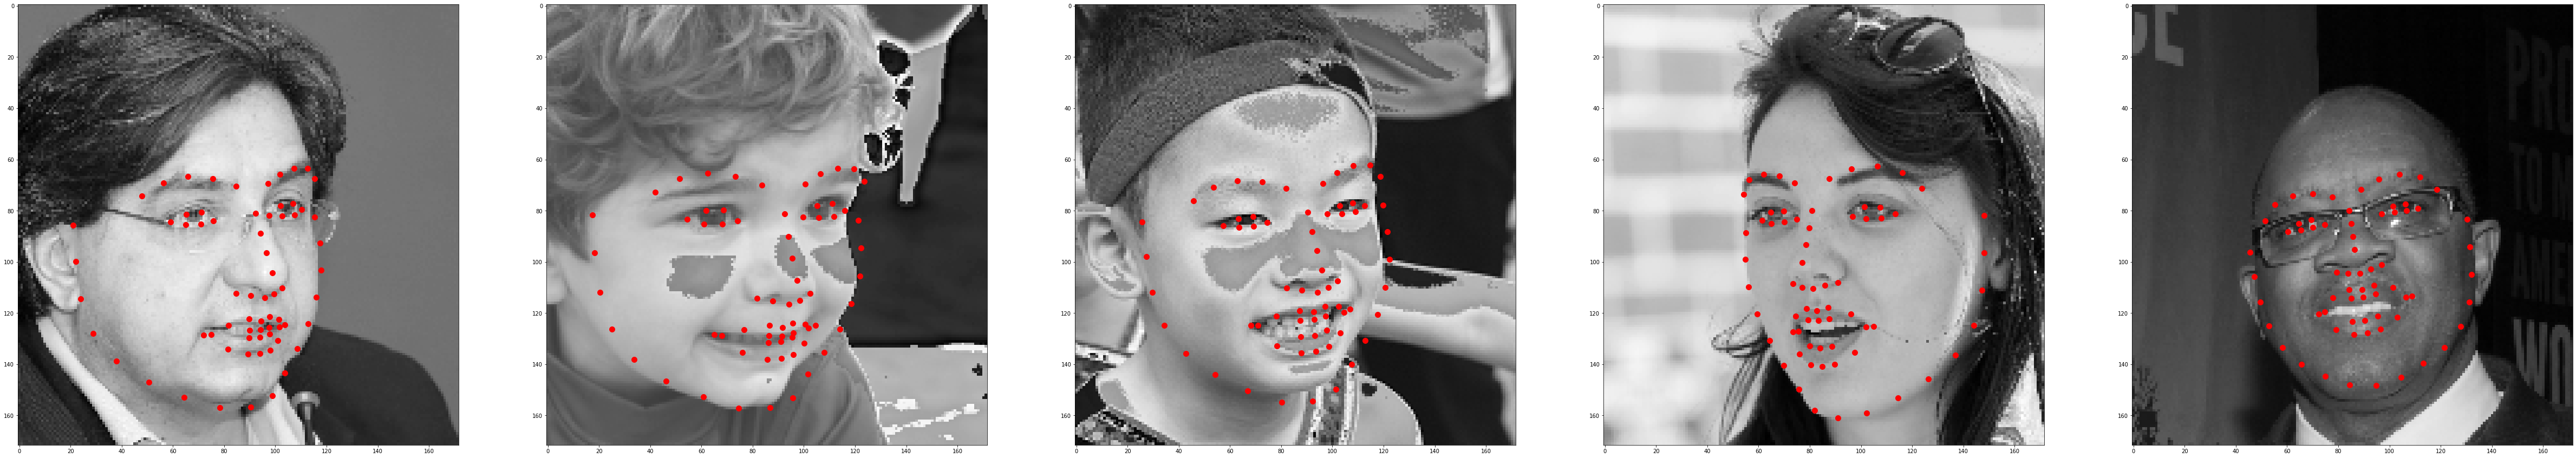

In [24]:
import matplotlib.pyplot as plt
# model_final=tf.keras.models.load_model(r"D:\Desktop\cours\3I\DetectionVisage\model_best_loss.h5")
fig = plt.figure(figsize=( 172 , 172 ))
for i in range( 1 , 6 ):
    sample_image = X_test[i]
    landmarks=model_final.predict(X_test)[i][0][0]
    fig.add_subplot( 1 , 10 , i )
    plt.imshow( sample_image , cmap='gray' )
    for j in range(0,136,2):
        plt.scatter( landmarks[j],landmarks[j+1],s=100, c='red' )
    
plt.show()

In [8]:
model_layers = [
    tf.keras.layers.BatchNormalization( input_shape=( 172 , 172 , 1 ) ),
    tf.keras.layers.Conv2D( 256 , kernel_size=(5,5 ) , strides=2 , activation='relu' ), 
    tf.keras.layers.Conv2D( 256 , kernel_size=( 5,5) , strides=2 , activation='relu' ),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D( 128 , kernel_size=(5,5) , strides=1 , activation='relu' ),
    tf.keras.layers.Conv2D( 128 , kernel_size=( 5,5 ) , strides=1 , activation='relu' ),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D( 128 , kernel_size=( 5,5 ) , strides=1 , activation='relu' ),
    tf.keras.layers.Conv2D( 128 , kernel_size=( 5,5) , strides=1 , activation='relu' ),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D( 64 , kernel_size=( 5,5 ) , strides=1 , activation='relu' ),
    tf.keras.layers.Conv2D( 64 , kernel_size=( 5,5 ) , strides=1 , activation='relu' ),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu'),
    tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' ),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu', ),
    tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu', ),
    tf.keras.layers.Conv2D( 136 , kernel_size=( 3 , 3 ) , strides=1 ),

]
model = tf.keras.Sequential( model_layers )
model.compile( loss=tf.keras.losses.mean_squared_error , optimizer=tf.keras.optimizers.Adam( lr=0.0001 ) , metrics=[ 'mse' ] )
model.summary()
history=model.fit(x=X_train,
                y=y_train,
                epochs=128,
                batch_size=4,
                validation_data=(X_test,y_test),
                callbacks=[callback,reduce_lr])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 172, 172, 1)      4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 84, 84, 256)       6656      
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 256)       1638656   
                                                                 
 batch_normalization_1 (Batc  (None, 40, 40, 256)      1024      
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 36, 128)       819328    
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       4

C:\Users\chene\AppData\Roaming\Python\Python310\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/128
2000/2000 [==============================] - 74s 33ms/step - loss: 316.7341 - mse: 316.7334 - val_loss: 34.3581 - val_mse: 34.3581 - lr: 1.0000e-04
Epoch 2/128
2000/2000 [==============================] - 66s 33ms/step - loss: 31.7511 - mse: 31.7511 - val_loss: 33.6153 - val_mse: 33.6153 - lr: 1.0000e-04
Epoch 3/128
2000/2000 [==============================] - 66s 33ms/step - loss: 25.4541 - mse: 25.4541 - val_loss: 29.8150 - val_mse: 29.8150 - lr: 1.0000e-04
Epoch 4/128
2000/2000 [==============================] - 65s 33ms/step - loss: 22.3132 - mse: 22.3132 - val_loss: 26.8108 - val_mse: 26.8109 - lr: 1.0000e-04
Epoch 5/128
2000/2000 [==============================] - 65s 33ms/step - loss: 20.6229 - mse: 20.6229 - val_loss: 20.0250 - val_mse: 20.0250 - lr: 1.0000e-04
Epoch 6/128
2000/2000 [==============================] - 65s 33ms/step - loss: 17.1053 - mse: 17.1054 - val_loss: 13.4015 - val_mse: 13.4015 - lr: 1.0000e-04
Epoch 7/128
2000/2000 [===========================

Epoch 54/128
2000/2000 [==============================] - 67s 33ms/step - loss: 1.1327 - mse: 1.1327 - val_loss: 1.9648 - val_mse: 1.9648 - lr: 1.0000e-04
Epoch 55/128
2000/2000 [==============================] - 66s 33ms/step - loss: 1.1311 - mse: 1.1311 - val_loss: 2.1244 - val_mse: 2.1244 - lr: 1.0000e-04
Epoch 56/128
2000/2000 [==============================] - 67s 33ms/step - loss: 1.1158 - mse: 1.1158 - val_loss: 2.0807 - val_mse: 2.0807 - lr: 1.0000e-04
Epoch 57/128
2000/2000 [==============================] - 66s 33ms/step - loss: 1.0966 - mse: 1.0966 - val_loss: 2.0668 - val_mse: 2.0668 - lr: 1.0000e-04
Epoch 58/128
2000/2000 [==============================] - 66s 33ms/step - loss: 1.0850 - mse: 1.0850 - val_loss: 2.1187 - val_mse: 2.1187 - lr: 1.0000e-04
Epoch 59/128
2000/2000 [==============================] - 66s 33ms/step - loss: 1.0606 - mse: 1.0606 - val_loss: 2.0770 - val_mse: 2.0770 - lr: 1.0000e-04
Epoch 60/128
2000/2000 [==============================] - 66s 33ms/ste

Epoch 107/128
2000/2000 [==============================] - 93s 47ms/step - loss: 0.7208 - mse: 0.7208 - val_loss: 1.8496 - val_mse: 1.8496 - lr: 1.0000e-04
Epoch 108/128
2000/2000 [==============================] - 93s 47ms/step - loss: 0.7178 - mse: 0.7178 - val_loss: 1.7413 - val_mse: 1.7413 - lr: 1.0000e-04
Epoch 109/128
2000/2000 [==============================] - 93s 47ms/step - loss: 0.7100 - mse: 0.7100 - val_loss: 1.7832 - val_mse: 1.7832 - lr: 1.0000e-04
Epoch 110/128
2000/2000 [==============================] - 93s 47ms/step - loss: 0.6987 - mse: 0.6987 - val_loss: 1.7963 - val_mse: 1.7963 - lr: 1.0000e-04
Epoch 111/128
2000/2000 [==============================] - 93s 47ms/step - loss: 0.7211 - mse: 0.7211 - val_loss: 1.8866 - val_mse: 1.8866 - lr: 1.0000e-04
Epoch 112/128
2000/2000 [==============================] - 93s 47ms/step - loss: 0.7070 - mse: 0.7070 - val_loss: 1.7641 - val_mse: 1.7641 - lr: 1.0000e-04
Epoch 113/128
2000/2000 [==============================] - 93s 4

In [16]:
model_final=tf.keras.models.load_model(r"D:\Desktop\cours\3I\DetectionVisage\model_best_loss.h5")
model_final.evaluate(X_train,y_train)
model_final.evaluate(X_test,y_test)

63/63 [==============================] - 4s 62ms/step - loss: 1.7414 - mse: 1.7414


[1.7413865327835083, 1.7413859367370605]

In [17]:
data=r"C:\Users\Authentification\PycharmProjects\ProjectFinalDetectionVisage\DetectionVisage\FaceDetectionTheo\Original Images\Dataset2"
ds=tf.keras.utils.image_dataset_from_directory(
    data,
    color_mode='grayscale',
    batch_size=4,
    image_size=(172, 172),
)
model_final=tf.keras.models.load_model(r"D:\Desktop\cours\3I\DetectionVisage\model_best_loss.h5")

img=ds.take(1)
init=time.perf_counter()
for i in range(100):
    model_final.predict(img)
time.perf_counter()-init

Found 17534 files belonging to 105 classes.


4.540114900097251

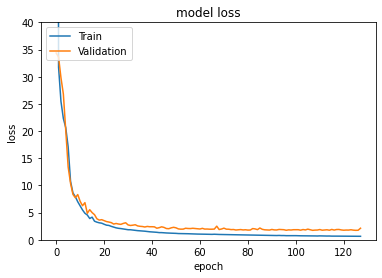

In [15]:
import matplotlib.pyplot as plt
def plot_graph(history):
    # summarize history for accuracy
#     plt.plot(history['accuracy'])
#     plt.plot(history['val_accuracy'])
#     plt.title('model accuracy')
#     plt.ylabel('accuracy')
#     plt.xlabel('epoch')
#     plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.ylim([0,40])
    plt.show()
plot_graph(history.history)